# Here you need to add the paper title, and then a small block of general explanation for a binder

# Experiments on neuromuscular efficiency of respiratory muscles

Import libraries

In [1]:
from scipy import interpolate as interp
import scipy
import pandas as pd
import glob
import os
import sys
import numpy as np
import numpy.matlib
import matplotlib.pyplot as plt
import ipywidgets as widgets
from datetime import datetime
%matplotlib widget

# The cell below will need to be changed for a generalized binder

In [2]:
# import helper functions
sys.path.insert(0, '..')

import resurfemg.preprocessing.ecg_removal as ecg_rm
import resurfemg.preprocessing.envelope as evl
import resurfemg.preprocessing.filtering as filt
import resurfemg.postprocessing.features as feat

from resurfemg.config.config import Config
config = Config()

# get new changes in our library i.e. the tmsisdk
sys.path.insert(0, '..')

from resurfemg.data_connector.tmsisdk_lite import Poly5Reader

# Initiation of output folder for experiments

In [3]:
# Output data - General path to direcotroy for saving .csvs and plots
main_output_dir = config.get_directory('preprocessed') + \
                    '/output_directory_name'
if not os.path.exists(main_output_dir):
    os.makedirs(main_output_dir)

# Root directory for patient data
root_patient_data_directory = \
    config.get_directory('root_patient_data_directory')

patient_idx = 0
#DEL measurement_dates = []

# Patient data selection

In [4]:
# Reruns should be done from this cell as the start

# Expected data structure:
# - Patient_01
# -- Measurement_date_XXXX_XX_01
# --- 001_Baseline
# --- 002_PEEP_step_01
# --- 003_PEEP_step_02
# --- 004_PEEP_step_03
# --- 005_PEEP_step_04
# -- Measurement_date_XXXX_XX_03
# --- 001_Baseline
# --- 002_PEEP_step_01
# --- 003_PEEP_step_02
# --- 004_PEEP_step_03
# --- 005_PEEP_step_04
# -- Patient_02
# -- Measurement_date_XXXX_XX_01
# etc.

In [5]:
# Select the folder of the patient of interest
# Run this cell once per patient

patient_folders = \
    glob.glob(root_patient_data_directory + '/**/', recursive=False)
patients = []
#DEL prev_measurement_dates = measurement_dates

for folder in patient_folders:
    name = folder.split("\\")[-2]
    patients.append(name)

btn_pt = widgets.Dropdown(  
    options=patients,
    value=patients[patient_idx],
    description='Select patient:',
    disabled=False,
)

date_idx = 0

display(btn_pt)

Dropdown(description='Select patient:', options=('MST001', 'MST002', 'MST003', 'MST004', 'MST005', 'MST006', '…

In [6]:
# Select the folder of the PEEP trial of interest of the selected patient
# measurement_date ~ PEEP-trial
# Run this cell once per patient/PEEP trial

patient = btn_pt.value
patient_idx =btn_pt.index

measurement_folders = glob.glob(root_patient_data_directory 
                                + '/' + patient 
                                + '/**/',
                                recursive=False
                                )
measurement_dates = []

for folder in measurement_folders:
    name = folder.split("\\")[-2]
    measurement_dates.append(name)

btn_measurement = widgets.Dropdown(
    options=measurement_dates,
    value=measurement_dates[date_idx],
    description='Select measurement date:',
    disabled=False,
)
display(btn_measurement)

Dropdown(description='Select measurement date:', options=('2021-12-24_09-29-46', '2021-12-27_09-16-26', '2021-…

In [7]:
# Identify all recordings available for the selected patient/measurement_date
# Rerun this ceel for each new PEEP-trial, as it also empties output parameter 
# list (big_data_list)!

# Identify all PEEP-step folders:
measurement_date = btn_measurement.value
date_idx = btn_measurement.index

windows_str = (root_patient_data_directory + '/' + patient + '/' 
               + measurement_date)
root_emg_directory = os.path.join(windows_str)

emg_pattern = os.path.join(root_emg_directory, '**/*.Poly5')
emg_and_vent_files = glob.glob(emg_pattern, recursive=True)

emg_files = []
vent_files = []

for file in emg_and_vent_files:
    if 'Draeger' in file:
        vent_files.append(file)
    else:
        emg_files.append(file)
list_of_numbers_strung = []

for i in range(len(emg_files)):
    list_of_numbers_strung.append(emg_files[i].split('\\')[-2])

# Initialise the analysis: empty the output parameter list and start at the 
# first recorded PEEP step (index -4)
big_data_list = []
PEEP_step_idx = -4

In [8]:
measurement_date

'2021-12-24_09-29-46'

Now you can pick a file from the list, which have been numbered.

In [91]:
# Select the PEEP step of interest. The selection menu initialises at the third 
# but last (index -4) recording

btn_PEEP_step = widgets.Dropdown(
    options=list_of_numbers_strung,
    value=str(emg_files[PEEP_step_idx].split('\\')[-2]),
    description='Picked File:',
    disabled=False,
)
display(btn_PEEP_step)

Dropdown(description='Picked File:', index=6, options=('001', '002', '003', '004', '005', '006', '007', '008',…

In [131]:
# Process the PEEP step selection 
PEEP_step_chosen = btn_PEEP_step.value
PEEP_step_idx = int(btn_PEEP_step.index)
emg_file_chosen = emg_files[PEEP_step_idx]
vent_file_chosen = vent_files[PEEP_step_idx]
print("The files you chose are:\n", emg_file_chosen, '\n', vent_file_chosen)

The files you chose are:
 P:/TNW/CRPH/Projects/2021_Warnaar_TOPSPIN_studie/4_Patient_data/1_RAW/MST001/2021-12-24_09-29-46\009\EMG_recording.Poly5 
 P:/TNW/CRPH/Projects/2021_Warnaar_TOPSPIN_studie/4_Patient_data/1_RAW/MST001/2021-12-24_09-29-46\009\Draeger_recording.Poly5


In [132]:
# Create a directory per PEEP trial to save the outputs .CSVs and plots to.
# Outputs are structured per patient/measurement_date:
# - Patient_01
# -- Measurement_date_XXXX_XX_01
# -- Measurement_date_XXXX_XX_02
# - Patient_02
# etc.

patient = emg_files[PEEP_step_idx].split('\\')[-3].split('/')[-2]
#DEL PEEP_step_number = emg_files[PEEP_step_idx].split('\\')[-2]

if not os.path.exists(main_output_dir + '/' + patient + '/'):
    os.makedirs(main_output_dir + '/' + patient + '/')

if not os.path.exists(main_output_dir + '/' + patient 
                      + '/' + measurement_date + '/'
):
    os.makedirs(main_output_dir + '/' + patient + '/' 
                + measurement_date + '/')

In [133]:
# Load the EMG and ventilator data recordings from the selected folders.
data_emg = Poly5Reader(emg_file_chosen)
data_vent = Poly5Reader(vent_file_chosen)
data_emg_samples = data_emg.samples[:data_emg.num_samples]
emg_sample_rate = data_emg.sample_rate
data_vent_samples = data_vent.samples[:data_vent.num_samples]
vent_sample_rate = data_vent.sample_rate

# Define the time series of the EMG and ventilator recordings
y_emg = data_emg_samples
y_vent = data_vent_samples

# Define the the axes
t_emg = [i/emg_sample_rate for i in range(len(y_emg[0, :]))]
t_vent = [i/vent_sample_rate for i in range(len(y_vent[0, :]))]

Reading file  P:/TNW/CRPH/Projects/2021_Warnaar_TOPSPIN_studie/4_Patient_data/1_RAW/MST001/2021-12-24_09-29-46\009\EMG_recording.Poly5
	 Number of samples:  654784 
	 Number of channels:  3 
	 Sample rate: 2048 Hz
Done reading data.
Reading file  P:/TNW/CRPH/Projects/2021_Warnaar_TOPSPIN_studie/4_Patient_data/1_RAW/MST001/2021-12-24_09-29-46\009\Draeger_recording.Poly5
	 Number of samples:  31968 
	 Number of channels:  3 
	 Sample rate: 100 Hz
Done reading data.


In [134]:
# Load settings from prior run
readme_file_name_default = config.get_directory('preprocessed') \
                        + '/2023_07_07_Set_Quality_criteria/' \
                        + patient + '/' + measurement_date + '/' \
                        + measurement_date + '_' + patient + '_' \
                        + PEEP_step_chosen + '_readme.txt'

if not os.path.exists(readme_file_name_default):
    readme_file_name_default = config.get_directory('preprocessed') \
                            + '/2023_04_SNR_good/' + patient + '/' \
                            + measurement_date + '/' \
                            + measurement_date + '_' + patient + '_' \
                            + PEEP_step_chosen + '_readme.txt'
try:
    with open(readme_file_name_default, 'r') as f:
        readme_str = f.read()
        
        settings_lines = readme_str.split('\n')
        
        t_start_default = float(settings_lines[1].split(' ')[-2])
        t_end_default = float(settings_lines[2].split(' ')[-2])

        gate_width_default = float(settings_lines[3].split(' ')[-2])/1000
        gate_threshold_default = float(settings_lines[4].split(' ')[-1])
        gate_ECG_shift_default = int(settings_lines[5].split(' ')[-2])
        
        time_shift_default = float(settings_lines[6].split(' ')[-2])

        Pocc_prominence_factor_default = float(settings_lines[7].split(' ')[-1])
        EMG_di_prominence_factor_default = float(settings_lines[8].split(' ')[-1])
        EMG_para_prominence_factor_default = float(
            settings_lines[9].split(' ')[-1])

        if len(settings_lines) > 12:
            N_gated = int(settings_lines[11].split(' ')[-1])
            if N_gated == 2:
                gate_twice = True
            else:
                gate_twice = False
            

        print(readme_str + '\n')
    f.close()
    prev_settings_loaded = True
except FileNotFoundError:
    print("Log file not found:")
    print(readme_file_name_default)
    prev_settings_loaded = False
except ValueError:
    print("Error while reading log file!")
    prev_settings_loaded = False

if not prev_settings_loaded:
    t_start_default = y_vent[-1]-100
    t_end_default = y_vent[-1]-10

    gate_width_default = 0.10
    gate_threshold_default = 0.30
    gate_ECG_shift_default = -10

    time_shift_default = 0.5                   #Draeger delay
    Pocc_prominence_factor_default = 0.8
    EMG_di_prominence_factor_default = 0.01
    EMG_para_prominence_factor_default = 0.01

emg_di_base_factor = 1
emg_para_base_factor = 1

MST001 / 2021-12-24_09-29-46 / 009
t_start: 210.0 s
t_end: 319.0 s
gate_width: 100 ms
gate_threshold: 0.3
gate_ECG_shift: -10 samples
time_shift: 0.5 s
Pocc_prominence_factor: 0.8
EMG_di_prominence_factor: 1
EMG_para_prominence_factor: 1
PEEP_set: 9.0
N_gated: 1
analysis_date: 2023-07-10 11:27:23.100330



In [135]:
#TODO: Enable # Default processing settings

# # Window including all end-expiratory occlusion manoeuvres (Pocc)
# t_start_default = t_vent[-1]-100
# t_end_default = t_vent[-1]-10

# # Gating settings
# #DEL gate_width = 0.1
# gate_width_default = 0.10
# gate_threshold_default = 0.30
# gate_ECG_shift_default = -10
# gate_twice = False

# # Peak detection settings
# time_shift_default = 0.5    # Delay between sEMG- and Pocc peak
# Pocc_prominence_factor_default = 0.8
# EMG_di_prominence_factor_default = 0.01
# EMG_para_prominence_factor_default = 0.01

# # Baseline detection settings
# # TODO: Delete base_factors as they are all 1
# emg_di_base_factor = 1
# emg_para_base_factor = 1


Text(0.5, 0, 't (s)')

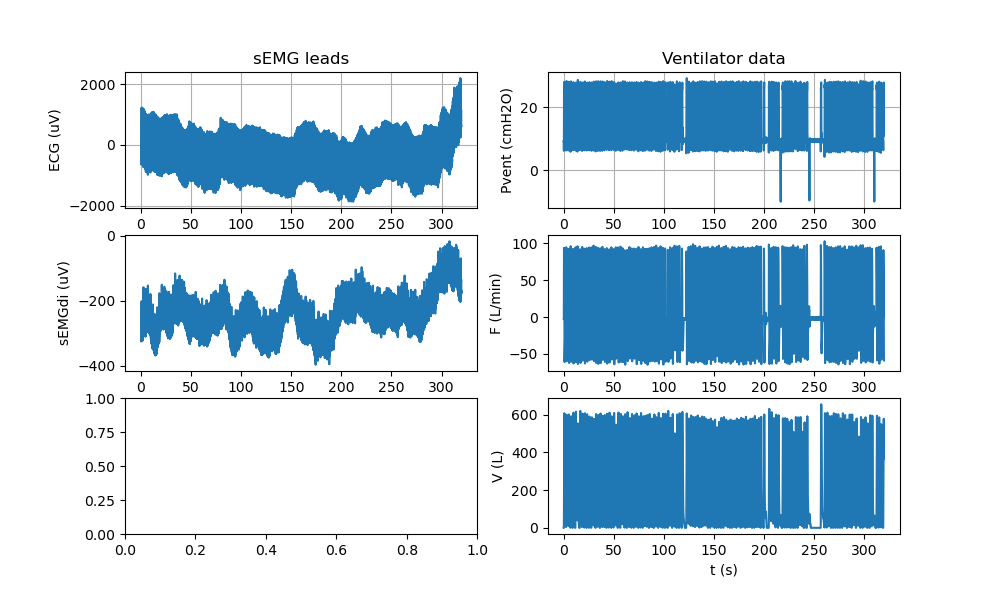

In [136]:
# Plot the raw data
fig, axis = plt.subplots(nrows=3, ncols=2, figsize=(10, 6))

axis[0, 0].grid(True)
axis[0, 0].plot(t_emg, y_emg[0])
axis[0, 0].set(title='sEMG leads')
axis[0, 0].set_ylabel('ECG (uV)')
axis[1, 0].plot(t_emg, y_emg[1])
axis[1, 0].set_ylabel('sEMGdi (uV)')
axis[1, 0].set_xlabel('t (s)')
#DEL axis[2, 0].plot(t_emg, y_emg[2])
# axis[2, 0].set_ylabel('sEMGpara (uV)')
# axis[2, 0].set_xlabel('t (s)')

axis[0, 1].set(title='Ventilator data')
axis[0, 1].grid(True)
axis[0, 1].plot(t_vent, y_vent[0])
axis[0, 1].set_ylabel('Pvent (cmH2O)')
axis[1, 1].plot(t_vent, y_vent[1])
axis[1, 1].set_ylabel('F (L/min)')
axis[2, 1].plot(t_vent, y_vent[2])
axis[2, 1].set_ylabel('V (L)')
axis[2, 1].set_xlabel('t (s)')

Here pick the part of the signal you want to look at. It is advised to never start at zero, or end after the signal, and the widgets have been constrained to do this.

In [137]:
# Enter the start and end time of the window in which the occlusions occur. Make
#  sure to take some margin around the peaks in the order of a couple of seconds
# to allow for the filtering algorithms to work properly. On the other hand, if 
# the window is to broad, the algorithms will also take longer to evaluate.

start_widget = widgets.BoundedFloatText(
    value=np.floor(t_start_default),
    min=1,
    max=t_vent[-1],
    step=1,
    description='Start:',
    disabled=False
)
end_widget = widgets.BoundedFloatText(
    value=np.floor(t_end_default),
    min=1,
    max=t_vent[-1],
    step=1,
    description='End:',
    disabled=False
)
widgets.VBox([start_widget, end_widget])

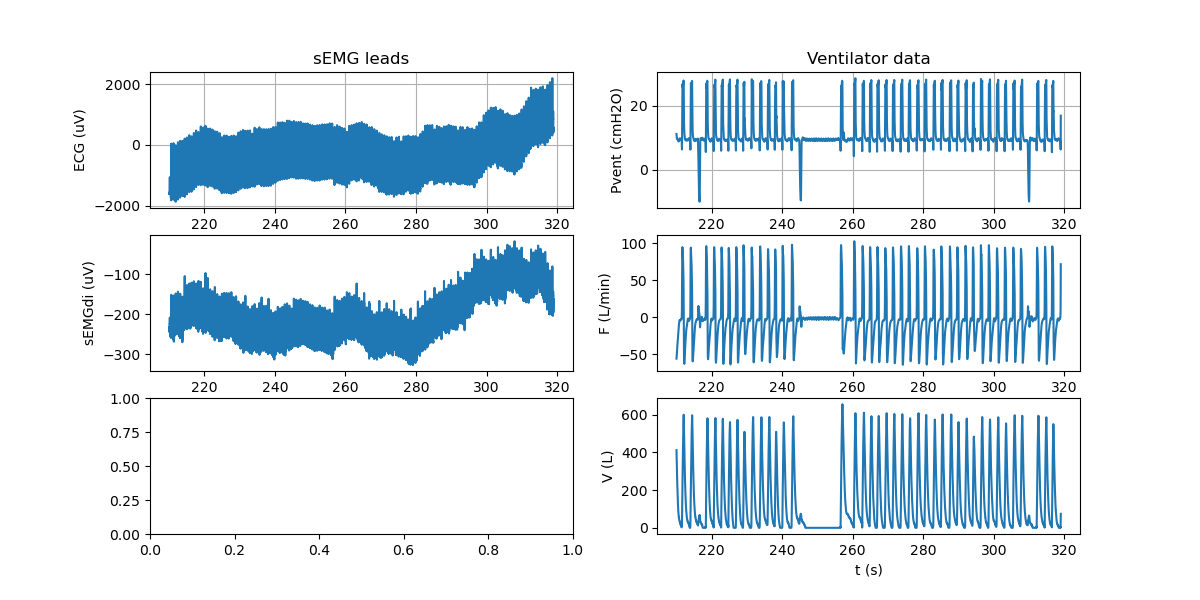

In [138]:
# Examine at the selected window:
# 1. Does it contain all occlusions? If not, adapt the start and/or end time to 
#    include all Pocc manoeuvres.
# 2. Does the window contain limited data before and after the occlusions 
#    (<10 s). If noy, you can adapt the start and/or end time to optimise 
#    calculation speed.

start = start_widget.value  
end = end_widget.value  
if ((0 > start) | (t_vent[-1] < start) | (0 > end) | (t_vent[-1] < end) 
    | (start >= end)):    
    print('Please make sure that 1) the start and end times are within the'  
          +' limits of the recording and 2) that the start time is before the' 
          + ' end time.')
else:
    # Plot the selected window.
    start_s = int(float(start)* emg_sample_rate)
    end_s = min([int(float(end)*emg_sample_rate), len(y_emg[0,:])-1])
    start_vent_s = int(float(start)* vent_sample_rate)
    end_vent_s = min(
        [int(float(end)* vent_sample_rate), len(y_vent[0,:])-1]
    )

    fig, axis = plt.subplots(nrows=3, ncols=2, figsize=(12, 6))
    axis[0, 0].set(title='sEMG leads')
    axis[0, 0].grid(True)
    axis[0, 0].plot(t_emg[int(start_s):int(end_s)], 
                    y_emg[0][int(start_s):int(end_s)])
    axis[0, 0].set_ylabel('ECG (uV)')
    axis[1, 0].plot(t_emg[int(start_s):int(end_s)], 
                    y_emg[1][int(start_s):int(end_s)])
    axis[1, 0].set_ylabel('sEMGdi (uV)')
    axis[1, 0].set_xlabel('t (s)')
    #DEL: axis[2, 0].plot(t_emg[int(start_s):int(end_s)], 
    #                 y_emg[2][int(start_s):int(end_s)])
    # axis[2, 0].set_ylabel('sEMGpara (uV)')
    # axis[2, 0].set_xlabel('t (s)')

    axis[0, 1].set(title='Ventilator data')
    axis[0, 1].grid(True)
    axis[0, 1].plot(
        t_vent[int(start_vent_s):int(end_vent_s)], 
        y_vent[0][int(start_vent_s):int(end_vent_s)]
    )
    axis[0, 1].set_ylabel('Pvent (cmH2O)')
    axis[1, 1].plot(
        t_vent[int(start_vent_s):int(end_vent_s)], 
        y_vent[1][int(start_vent_s):int(end_vent_s)]
    )
    axis[1, 1].set_ylabel('F (L/min)')
    axis[2, 1].plot(
        t_vent[int(start_vent_s):int(end_vent_s)], 
        y_vent[2][int(start_vent_s):int(end_vent_s)]
    )
    axis[2, 1].set_ylabel('V (L)')
    axis[2, 1].set_xlabel('t (s)')

# Pre-processing

In [139]:
# Eliminate the baseline wander from the data using a band-pass filter
bd_filtered_file_data = filt.emg_bandpass_butter_sample(
    data_emg_samples, 1, 500, 2048, output='sos')
    
processed_data_emg_di = bd_filtered_file_data[1]
#DEL processed_data_emg_para = bd_filtered_file_data[2]

In [140]:
# Gating settings

# Window size to plot the gating results from
plot_window = 5         

# QRS peak detection settings
# peak_fraction = 0.30
peak_fraction = gate_threshold_default     # Minimal relative peak height
peak_width = 0.001
peak_dist = int(emg_sample_rate/3)

# Shift of gated in samples relative to detected peaks      
# ECG_shift = -10
ECG_shift = gate_ECG_shift_default

# Gate width in seconds
# gate_width = 0.10
gate_width = gate_width_default

In [141]:
# Apply QRS gating

# Detect ECG peaks on 1Hz high-pass filtered signals
ecg = bd_filtered_file_data[0]
ecg_rms = evl.full_rolling_rms(ecg, 10)
max_ecg_rms = max(
    ecg_rms[int(start_s):int(start_s+plot_window*emg_sample_rate)])
min_ecg_rms = min(
    ecg_rms[int(start_s):int(start_s+plot_window*emg_sample_rate)])
peak_height = peak_fraction*(max_ecg_rms - min_ecg_rms)

ECG_peaks, properties  = scipy.signal.find_peaks(
    ecg_rms, 
    height=peak_height, 
    width=peak_width*emg_sample_rate, 
    distance=peak_dist
)
ECG_peaks = ECG_peaks - ECG_shift

# Filter EXG signals 20Hz high pass
ECG_h20 = filt.emg_bandpass_butter_sample(ecg, 20, 500, 2048, output='sos')
emg_di_h20 = filt.emg_bandpass_butter_sample(
    processed_data_emg_di, 20, 500, 2048, output='sos')
#DEL emg_para_h20 = filt.emg_bandpass_butter_sample(
#     processed_data_emg_para, 20, 500, 2048, output='sos')

# Gate ECG and EMG signal
# Fill methods 0: Zeros, 1: Interpolate start-end, 2: Average prior data, 
# 3: Moving average
gate_fill_method = 3    
gate_width_samples = int(gate_width*emg_sample_rate)

gate_samples = list()
for i in range(len(ECG_peaks)):
    for k in range(
        int(ECG_peaks[i]-gate_width_samples/2),
        int(ECG_peaks[i]+gate_width_samples/2)
    ):
        gate_samples.append(k)

ECG_gated = ecg_rm.gating(
    ECG_h20, ECG_peaks, gate_width=gate_width_samples, method=3)
emg_di_gated = ecg_rm.gating(
    emg_di_h20, ECG_peaks, gate_width=gate_width_samples, method=3)
#DEL emg_para_gated = ecg_rm.gating(
# emg_para_h20, ECG_peaks, gate_width=gate_width_samples, method=3)


In [142]:
# Apply gating twice, e.g., in case of splitted QRS complex or pacing
if gate_twice == True:
    # Detect ECG peaks on 1Hz high-pass filtered signals
    ecg = ECG_gated
    ecg_rms = evl.full_rolling_rms(ecg, 10)
    max_ecg_rms = max(
        ecg_rms[int(start_s):int(start_s+plot_window*emg_sample_rate)])
    min_ecg_rms = min(
        ecg_rms[int(start_s):int(start_s+plot_window*emg_sample_rate)])
    peak_height = peak_fraction*(max_ecg_rms - min_ecg_rms)

    ECG_peaks, properties  = scipy.signal.find_peaks(
        ecg_rms, 
        height=peak_height, 
        width=peak_width*emg_sample_rate, 
        distance=peak_dist
    )
    ECG_peaks = ECG_peaks - ECG_shift

    # Gate ECG and EMG signal
    # Fill methods: 0: Zeros, 1: Interpolate start-end, 2: Average prior data, 
    # 3: Moving average
    gate_fill_method = 3    
    gate_width_samples = int(gate_width*emg_sample_rate)

    gate_samples = list()
    for i in range(len(ECG_peaks)):
        for k in range(
            int(ECG_peaks[i]-gate_width_samples/2),
            int(ECG_peaks[i]+gate_width_samples/2)
        ):
            gate_samples.append(k)

    ECG_gated = ecg_rm.gating(
        ECG_gated, ECG_peaks, gate_width=gate_width_samples, method=3)
    emg_di_gated = ecg_rm.gating(
        emg_di_gated, ECG_peaks, gate_width=gate_width_samples, method=3)
    #DEL emg_para_gated = ecg_rm.gating(
    #     emg_para_gated, ECG_peaks, gate_width=gate_width_samples, method=3)


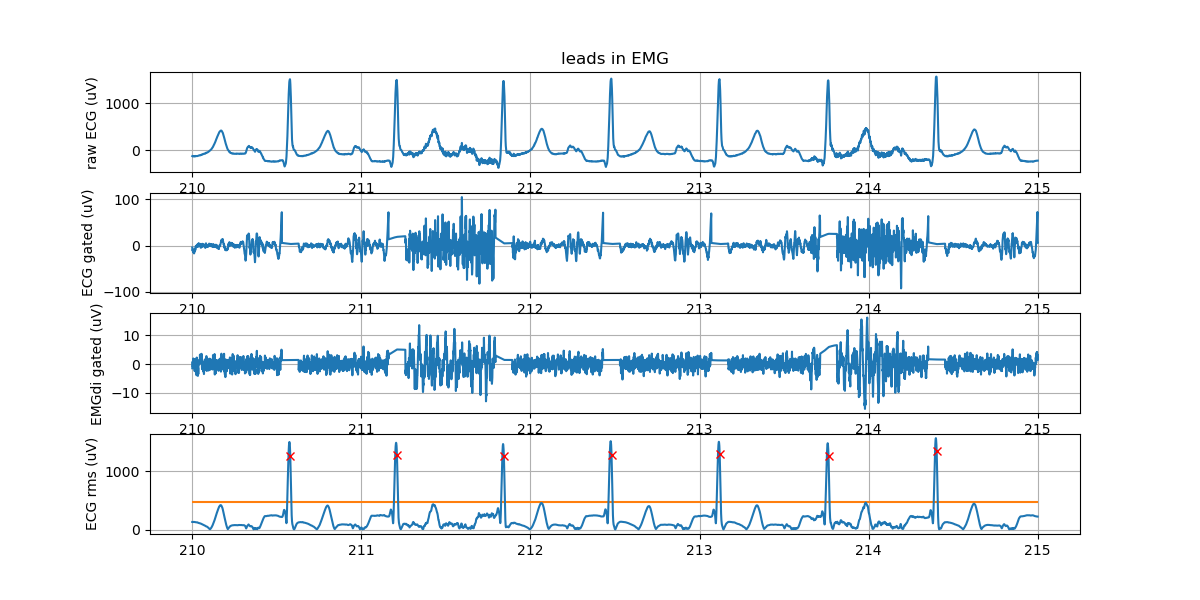

In [143]:
# Plot gating result

fig, axis = plt.subplots(nrows=4, ncols=1, figsize=(12, 6))
start_i = int(start_s)
end_i = int(start_s+plot_window*2048)
axis[0].grid(True)
axis[0].plot(t_emg[start_i:end_i], bd_filtered_file_data[0, start_i:end_i])
axis[0].set_ylabel('raw ECG (uV)')

axis[0].set(title='leads in EMG')
axis[1].grid(True)
axis[1].plot(t_emg[start_i:end_i], ECG_gated[start_i:end_i])
axis[1].set_ylabel('ECG gated (uV)')
axis[2].grid(True)
axis[2].plot(t_emg[start_i:end_i], emg_di_gated[start_i:end_i])
axis[2].set_ylabel('EMGdi gated (uV)')
#DEL axis[3].grid(True)
# axis[3].plot(t_emg[start_i:end_i], emg_para_gated[start_i:end_i])
# axis[3].set_ylabel('EMGpara gated (uV)')
#
# axis[4].grid(True)
# axis[4].plot(t_emg[start_i:end_i], ecg_rms[start_i:end_i])
# axis[4].set_ylabel('ECG rms (uV)')
# axis[4].hlines(
#     y=peak_height, 
#     xmin=t_emg[start_i], 
#     xmax=t_emg[end_i],
#     color = "C1"
# )
# 
# for idx in range(len(ECG_peaks)):
#     if ((ECG_peaks[idx] > int(start_s)) 
#         & (ECG_peaks[idx] < int(start_s+plot_window*2048))):
#         axis[4].plot(t_emg[ECG_peaks[idx]], ecg_rms[ECG_peaks[idx]],'rx')

axis[3].grid(True)
axis[3].plot(t_emg[start_i:end_i], ecg_rms[start_i:end_i])
axis[3].set_ylabel('ECG rms (uV)')
axis[3].hlines(
    y=peak_height, 
    xmin=t_emg[start_i], 
    xmax=t_emg[end_i],
    color = "C1"
)

for idx in range(len(ECG_peaks)):
    if ((ECG_peaks[idx] > int(start_s)) 
        & (ECG_peaks[idx] < int(start_s+plot_window*2048))):
        axis[3].plot(t_emg[ECG_peaks[idx]], ecg_rms[ECG_peaks[idx]],'rx')


Calculate root mean squared (RMS)

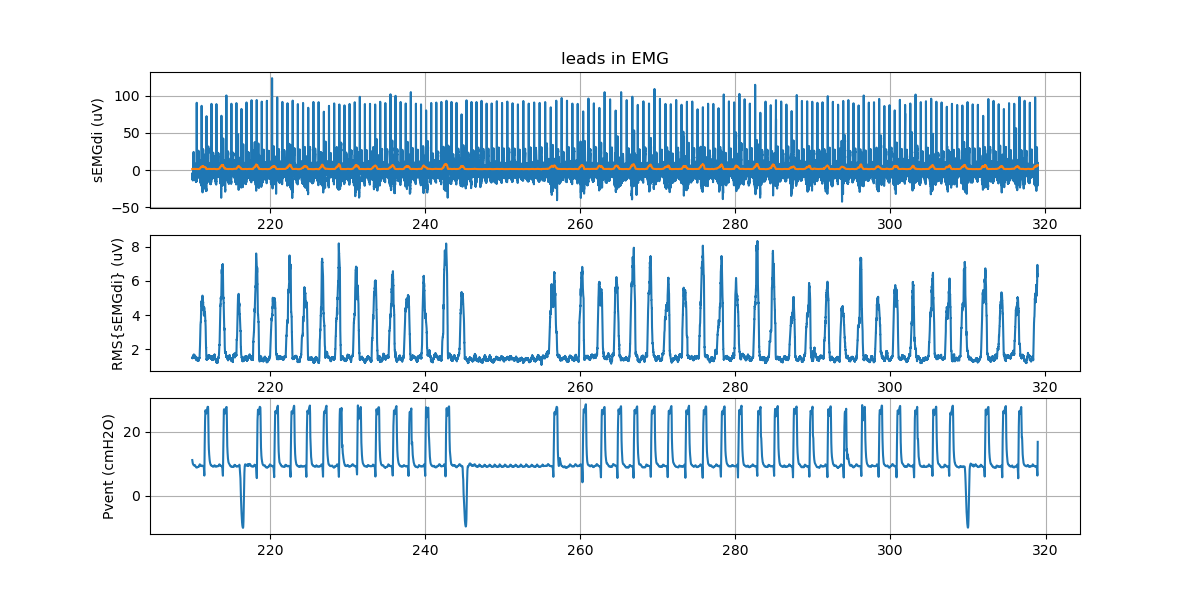

In [144]:
# Calculate the moving-RMS over the sEMG signal
RMS_window_ms = 200
RMS_windows_samp = int(RMS_window_ms / 1000 *  emg_sample_rate)

RMS_data_emg_di = evl.full_rolling_rms(emg_di_gated, RMS_windows_samp)
#DEL RMS_data_emg_para = evl.full_rolling_rms(emg_para_gated, RMS_windows_samp)

fig, axis = plt.subplots(nrows=3, ncols=1, figsize=(12, 6))
axis[0].set(title='leads in EMG')
axis[0].set_ylabel('sEMGdi (uV)')
axis[0].grid(True)
axis[0].plot(t_emg[int(start_s):int(end_s)], 
             processed_data_emg_di[int(start_s):int(end_s)])

axis[0].plot(t_emg[int(start_s):int(end_s)], 
             RMS_data_emg_di[int(start_s):int(end_s)])

axis[1].set_xlabel('t (s)')
axis[1].set_ylabel('RMS{sEMGdi} (uV)')
axis[1].plot(t_emg[int(start_s):int(end_s)], 
             RMS_data_emg_di[int(start_s):int(end_s)])

#DEL axis[2].set(title='leads in EMG')
# axis[2].set_ylabel('sEMGpara (uV)')
# axis[2].grid(True)
# axis[2].plot(t_emg[int(start_s):int(end_s)], 
#              processed_data_emg_para[int(start_s):int(end_s)])
# axis[2].plot(t_emg[int(start_s):int(end_s)], 
#              RMS_data_emg_para[int(start_s):int(end_s)])

# axis[3].set_xlabel('t (s)')
# axis[3].set_ylabel('RMS{sEMGpara} (uV)')
# axis[3].plot(t_emg[int(start_s):int(end_s)], 
#              RMS_data_emg_para[int(start_s):int(end_s)])

# axis[4].set_ylabel('P_vent (cmH2O)')
# axis[4].grid(True)
# axis[4].plot(t_vent[int(start_vent_s):int(end_vent_s)], 
#              y_vent[0][int(start_vent_s):int(end_vent_s)])

axis[2].set_ylabel('Pvent (cmH2O)')
axis[2].grid(True)
axis[2].plot(t_vent[int(start_vent_s):int(end_vent_s)], 
             y_vent[0][int(start_vent_s):int(end_vent_s)])

# Feature extraction

In [145]:
# Detect the set PEEP level

# Find end-expiration samples by finding the minimal values in V_vent
V_vent_up_to_start = y_vent[2][:int(start_vent_s)]
V_ee_PKS, _ = scipy.signal.find_peaks(-V_vent_up_to_start)

# Calculate PEEP as the median value of Pvent at end-expiration
PEEP_set = np.floor(np.median(y_vent[0, V_ee_PKS]))

PEEP_set

9.0

In [146]:
# Old moving baseline on pressure and EMG signals for baseline crossing 
# detection in accordance with Graßhoff et al. (2021)

emg_baseline_factor = 1

baseline_W_emg = 5 * emg_sample_rate  # window length
baseline_W_vent = 5 * vent_sample_rate  # window length

emg_di_rolling_base_line_old = np.zeros(
    (len(RMS_data_emg_di[int(start_s):int(end_s)]), ))
#DEL emg_para_rolling_base_line_old = np.zeros(
#     (len(RMS_data_emg_para[int(start_s):int(end_s)]), ))

for idx in range(0, int(end_s)-int(start_s), int(emg_sample_rate/5)):
    start_i = max([int(start_s), int(start_s)+idx-int(baseline_W_emg/2)])
    end_i = min([int(end_s), int(start_s)+idx+int(baseline_W_emg/2)])
    baseline_value_emg_di = np.percentile(
        RMS_data_emg_di[start_i:end_i], 33)
    #DEL baseline_value_emg_para = np.percentile(
    #     RMS_data_emg_para[start_i:end_i], 33)
    for i in range(idx, 
                   min([idx+int(emg_sample_rate/5), int(end_s)-int(start_s)])
    ):
        emg_di_rolling_base_line_old[i] = \
            emg_baseline_factor * baseline_value_emg_di
        #DEL emg_para_rolling_base_line_old[i] = \
        #     emg_baseline_factor * baseline_value_emg_para

In [147]:
# Augmented moving baseline for EMG signals for baseline crossing detection

# Baseline windows
baseline_W_emg = int(7.5 * emg_sample_rate)  # window length
baseline_W_vent = int(7.5 * vent_sample_rate)  # window length

#TODO Parameters to tune the baseline behaviour
emg_baseline_factor = 1.0       # Amplification factor of the moving baseline
var_window_factor = int(1)      # Adapt the variance window to be different from
                                # the moving baseline window.


# Calculate the default moving baselines
emg_di_rolling_base_line = np.zeros(
    (len(RMS_data_emg_di[int(start_s):int(end_s)]), ))
#DEL: emg_para_rolling_base_line = np.zeros(
#     (len(RMS_data_emg_para[int(start_s):int(end_s)]), ))
P_rolling_base_line = np.zeros(
    (len(y_vent[0, int(start_vent_s):int(end_vent_s)]), ))

# Calculate the moving baseline over the P_vent signal
# TODO: Paw vs Pvent vs P_vent
for idx in range(0, 
                 int(end_vent_s)-int(start_vent_s), 
                 int(vent_sample_rate/5)
):
    start_i = max([int(start_vent_s), int(
        start_vent_s)+idx-int(baseline_W_vent/2)])
    end_i = min([int(end_vent_s), int(start_vent_s) +
                idx+int(baseline_W_vent/2)])
    P_rolling_base_line[idx] = np.percentile(y_vent[0, start_i:end_i], 33)

    baseline_value_P = np.percentile(y_vent[0, start_i:end_i], 33)
    for i in range(idx, 
            min([idx+int(vent_sample_rate/5), 
                 int(end_vent_s)-int(start_vent_s)])
    ):
        P_rolling_base_line[i] = baseline_value_P

# Calculate the "default" moving baseline over the sEMG data over a 7.5s window
for idx in range(0, int(end_s)-int(start_s), int(emg_sample_rate/5)):
    start_i = max([int(start_s), int(start_s)+idx-int(baseline_W_emg/2)])
    end_i = min([int(end_s), int(start_s)+idx+int(baseline_W_emg/2)])
    baseline_value_emg_di = np.percentile(
        RMS_data_emg_di[start_i:end_i], 33)
    #DEL: baseline_value_emg_para = np.percentile(
    #     RMS_data_emg_para[start_i:end_i], 33)
    for i in range(idx, 
                   min([idx+int(emg_sample_rate/5), int(end_s)-int(start_s)])
    ):
        emg_di_rolling_base_line[i] = \
            emg_baseline_factor * baseline_value_emg_di
        #DEL emg_para_rolling_base_line[i] = \
        #     emg_baseline_factor * baseline_value_emg_para

# Calculate the augmented moving baselines for the sEMG data
di_baseline_series = pd.Series(emg_di_rolling_base_line)
di_baseline_std = di_baseline_series.rolling(var_window_factor*baseline_W_emg, 
                                 min_periods=1, 
                                 center=True).std().values
di_baseline_mean = di_baseline_series.rolling(var_window_factor*baseline_W_emg, 
                                 min_periods=1, 
                                 center=True).mean().values                                 

#DEL para_baseline_series = pd.Series(emg_para_rolling_base_line)
# para_baseline_std = para_baseline_series.rolling(
#     var_window_factor*baseline_W_emg, 
#     min_periods=1, 
#     center=True).std().values
# para_baseline_mean = para_baseline_series.rolling(
#     var_window_factor*baseline_W_emg, 
#     min_periods=1, 
#     center=True).mean().values

# Augmented signal := EMG + abs(dEMG/dt_smoothed)
ma_window = window=emg_sample_rate//2
augmented_perc = 25
perc_window = emg_sample_rate

# TODO y_di standardiseren
y_di = RMS_data_emg_di[int(start_s):int(end_s)]
s_di = pd.Series(y_di - emg_di_rolling_base_line)
EMG_di_MA = s_di.rolling(window=ma_window, center=True).mean().values
dEMG_di_dt = (EMG_di_MA[1:] - EMG_di_MA[:-1] ) * emg_sample_rate
EMG_di_aug = y_di[:-1] + np.abs(dEMG_di_dt)

#DEL y_para = RMS_data_emg_para[int(start_s):int(end_s)]
# s_para = pd.Series(y_para - emg_para_rolling_base_line)
# EMG_para_MA = s_para.rolling(window=ma_window, center=True).mean().values
# dEMG_para_dt = (EMG_para_MA[1:] - EMG_para_MA[:-1] ) * emg_sample_rate
# EMG_para_aug = y_para[:-1] + np.abs(dEMG_para_dt)

# Rolling baseline of augmented signals
emg_di_aug_rolling_base_line = np.zeros(
    (len(RMS_data_emg_di[int(start_s):int(end_s)-1]), ))
#DEL emg_para_aug_rolling_base_line = np.zeros(
#     (len(RMS_data_emg_para[int(start_s):int(end_s)-1]), ))

# Run the moving median filter over the augmented signal to obtain the baseline
for idx in range(0, int(end_s-1)-int(start_s), perc_window):
    start_i = max([0, idx-int(baseline_W_emg)])
    end_i = min([int(end_s-start_s-1), idx+int(baseline_W_emg)])

    baseline_value_emg_di = np.nanpercentile(
        EMG_di_aug[start_i:end_i], augmented_perc)

    #DEL baseline_value_emg_para = np.nanpercentile(
    #     EMG_para_aug[start_i:end_i], augmented_perc)
    
    for i in range(idx, 
                   min([idx+int(perc_window), int(end_s-1)-int(start_s)])
    ):
        emg_di_aug_rolling_base_line[i] = 1.2 * baseline_value_emg_di
        #DEL emg_para_aug_rolling_base_line[i] = 1.2 * baseline_value_emg_para

Detect the end-expiratory occlusions (Pocc)

In [148]:
# # Peak detection settings
# Pocc_prominence_factor = 0.8
Pocc_prominence_factor = Pocc_prominence_factor_default

Pocc_prominence_factor

0.8

In [149]:
# Detect (negative) occlussion peaks in pressure signal
treshold = 0
width = int(0.1 * vent_sample_rate)
prominence = Pocc_prominence_factor *np.abs( PEEP_set - min(y_vent[0]))
height = -(PEEP_set - Pocc_prominence_factor * 
           np.abs( PEEP_set - min(y_vent[0])))
distance = int(0.5 * vent_sample_rate)

x = y_vent[0, int(start_vent_s):int(end_vent_s)]
P_occ_peaks, properties  = scipy.signal.find_peaks(
    -x, 
    height=height, 
    prominence=prominence, 
    width=width, 
    distance=distance
)

# Detect Pocc on- and offset using moving baseline crossings
PEEP_crossings_idx = np.argwhere(np.diff(np.sign(x - P_rolling_base_line)) != 0)

P_occ_starts = np.zeros((len(P_occ_peaks),), dtype=int)
P_occ_ends = np.zeros((len(P_occ_peaks),), dtype=int)
for idx in range(len(P_occ_peaks)):
    PEEP_crossings_idx_sub = np.sign(
        x[:P_occ_peaks[idx]] - P_rolling_base_line[:P_occ_peaks[idx]])
    a = np.argmin(
        P_occ_peaks[idx] - np.argwhere(np.diff(PEEP_crossings_idx_sub) != 0))
    P_occ_starts[idx] = int(PEEP_crossings_idx[a])
    P_occ_ends[idx] = int(PEEP_crossings_idx[a+1])

In [150]:
# Data sanity check: Make sure occlusion manoeuvres have been detected
if len(P_occ_starts) == 0 or len(P_occ_peaks) ==0  or len(P_occ_ends) == 0:
    print('No occlussion peaks were detected in the selected window,' 
          + 'please examine the data. Selected another window or file, '
          + 'accordingly')
else:
    print('You may continue!')

You may continue!


EMG peak identification

In [151]:
# EMG peak detection parameters:

# Threshold peak height as fraction of max peak height 
# EMG_di_prominence_factor = 0.5         
EMG_di_prominence_factor = EMG_di_prominence_factor_default

# Threshold peak height as fraction of max peak height
# EMG_para_prominence_factor = 0.5       
EMG_para_prominence_factor = EMG_para_prominence_factor_default

# Draeger delay
# vent_delay = 0.5
vent_delay = time_shift_default = 0.5                   

emg_peak_width = 0.2
percentile_border = 90

In [152]:
# Find diaphragm EMG peaks and baseline crossings using the old baseline

y_di = RMS_data_emg_di[int(start_s):int(end_s)]
treshold = 0
width = int(emg_peak_width * emg_sample_rate)
prominence = EMG_di_prominence_factor * \
    (np.nanpercentile(y_di - emg_di_rolling_base_line_old, 75) 
     + np.nanpercentile(y_di - emg_di_rolling_base_line_old, 50))
EMG_peaks_di, properties = scipy.signal.find_peaks(
    y_di, height=treshold, prominence=prominence, width=width)

# Link EMG peak closest to occlusion pressures
EMG_di_occ_peaks = np.zeros((len(P_occ_peaks),), dtype=int)
PKS_idx = np.zeros((len(P_occ_peaks),), dtype=int)
for idx in range(len(P_occ_peaks)):
    P_occ_peak_converted = P_occ_peaks[idx]/vent_sample_rate*emg_sample_rate
    PKS_idx[idx] = np.argmin(
        np.abs(EMG_peaks_di + vent_delay * emg_sample_rate 
               - P_occ_peak_converted)
    )

    EMG_di_occ_peaks[idx] = EMG_peaks_di[PKS_idx[idx]]

# Old method
baseline_crossings_idx = np.argwhere(
    np.diff(np.sign(y_di - emg_di_rolling_base_line_old)) != 0)

EMG_di_occ_starts_old_base = np.zeros((len(P_occ_peaks),), dtype=int)
EMG_di_occ_ends_old_base = np.zeros((len(P_occ_peaks),), dtype=int)
for idx in range(len(P_occ_peaks)):
    baseline_crossings_idx_sub = np.sign(
        y_di[:EMG_di_occ_peaks[idx]] 
        - emg_di_rolling_base_line_old[:EMG_di_occ_peaks[idx]]
    )
    a = np.argmin(
        EMG_di_occ_peaks[idx] 
        - np.argwhere(np.diff(baseline_crossings_idx_sub) != 0))
    
    EMG_di_occ_starts_old_base[idx] = int(baseline_crossings_idx[a])
    
    if a < len(baseline_crossings_idx) - 1:
        EMG_di_occ_ends_old_base[idx] = int(baseline_crossings_idx[a+1])
    else:
        EMG_di_occ_ends_old_base[idx] = len(y_di) - 1 

In [153]:
# Find diaphragm EMG peaks and baseline crossings using the new baseline

y_di = RMS_data_emg_di[int(start_s):int(end_s)]
treshold = 0
width = int(emg_peak_width * emg_sample_rate)
prominence = EMG_di_prominence_factor * \
    (np.nanpercentile(y_di - emg_di_rolling_base_line, 75) 
     + np.nanpercentile(y_di - emg_di_rolling_base_line, 50))
EMG_peaks_di, properties = scipy.signal.find_peaks(
    y_di, height=treshold, prominence=prominence, width=width)

# Link EMG peak closest to occlusion pressures
EMG_di_occ_peaks = np.zeros((len(P_occ_peaks),), dtype=int)
PKS_idx = np.zeros((len(P_occ_peaks),), dtype=int)
for idx in range(len(P_occ_peaks)):
    P_occ_peak_converted = P_occ_peaks[idx]/vent_sample_rate*emg_sample_rate
    PKS_idx[idx] = np.argmin(
        np.abs(EMG_peaks_di + vent_delay * emg_sample_rate 
               - P_occ_peak_converted)
    )

    EMG_di_occ_peaks[idx] = EMG_peaks_di[PKS_idx[idx]]

emg_di_rolling_base_line_aug = emg_di_rolling_base_line * (1+ 
    np.nanmedian(y_di[EMG_di_occ_peaks]) * di_baseline_std 
    / di_baseline_mean **2
)
    

baseline_crossings_idx = np.argwhere(
    np.diff(np.sign(y_di - emg_di_rolling_base_line_aug)) != 0)

EMG_di_occ_starts_new = np.zeros((len(P_occ_peaks),), dtype=int)
EMG_di_occ_ends_new = np.zeros((len(P_occ_peaks),), dtype=int)
for idx in range(len(P_occ_peaks)):
    baseline_crossings_idx_sub = np.sign(
        y_di[:EMG_di_occ_peaks[idx]] 
        - emg_di_rolling_base_line_aug[:EMG_di_occ_peaks[idx]]
    )
    a = np.argmin(
        EMG_di_occ_peaks[idx] 
        - np.argwhere(np.diff(baseline_crossings_idx_sub) != 0))
    
    EMG_di_occ_starts_new[idx] = int(baseline_crossings_idx[a])
    
    if a < len(baseline_crossings_idx) - 1:
        EMG_di_occ_ends_new[idx] = int(baseline_crossings_idx[a+1])
    else:
        EMG_di_occ_ends_new[idx] = len(y_di) - 1 

In [154]:
#DEL # Find parasternal EMG peaks and baseline crossings using the old baseline

# y_para = RMS_data_emg_para[int(start_s):int(end_s)]
# treshold = 0
# width = int(emg_peak_width * emg_sample_rate)
# prominence = EMG_para_prominence_factor * \
#     (np.nanpercentile(y_para - emg_para_rolling_base_line_old, 75) 
#      + np.nanpercentile(y_para - emg_para_rolling_base_line_old, 50))

# EMG_peaks_para, properties = scipy.signal.find_peaks(
#     y_para, height=treshold, prominence=prominence, width=width)

# # Link EMG peak closest to occlusion pressures
# EMG_para_occ_peaks = np.zeros((len(P_occ_peaks),), dtype=int)
# PKS_idx = np.zeros((len(P_occ_peaks),), dtype=int)
# for idx in range(len(P_occ_peaks)):
#     P_occ_peak_converted = P_occ_peaks[idx]/vent_sample_rate*emg_sample_rate
#     PKS_idx[idx] = np.argmin(
#         np.abs(EMG_peaks_para + vent_delay * emg_sample_rate 
#                - P_occ_peak_converted))
#     EMG_para_occ_peaks[idx] = EMG_peaks_para[PKS_idx[idx]]

# # Old method
# baseline_crossings_idx = np.argwhere(
#     np.diff(np.sign(y_para - emg_para_rolling_base_line_old)) != 0)

# EMG_para_occ_starts_old_base = np.zeros((len(P_occ_peaks),), dtype=int)
# EMG_para_occ_ends_old_base = np.zeros((len(P_occ_peaks),), dtype=int)
# for idx in range(len(P_occ_peaks)):
#     baseline_crossings_idx_sub = np.sign(
#         y_para[:EMG_para_occ_peaks[idx]] 
#         - emg_para_rolling_base_line_old[:EMG_para_occ_peaks[idx]])
#     a = np.argmin(
#         EMG_para_occ_peaks[idx] 
#         - np.argwhere(np.diff(baseline_crossings_idx_sub) != 0))
#     EMG_para_occ_starts_old_base[idx] = int(baseline_crossings_idx[a])
#     if a < len(baseline_crossings_idx) - 1:
#         EMG_para_occ_ends_old_base[idx] = int(baseline_crossings_idx[a+1])
#     else:
#         EMG_para_occ_ends_old_base[idx] = len(y_para) - 1 

# EMG_para_occ_starts_old_base, EMG_para_occ_ends_old_base

In [155]:
#DEL # Find parasternal EMG peaks and baseline crossings using the new baseline

# y_para = RMS_data_emg_para[int(start_s):int(end_s)]
# treshold = 0
# width = int(emg_peak_width * emg_sample_rate)
# prominence = EMG_para_prominence_factor * \
#     (np.nanpercentile(y_para - emg_para_rolling_base_line, 75) 
#      + np.nanpercentile(y_para - emg_para_rolling_base_line, 50))

# EMG_peaks_para, properties = scipy.signal.find_peaks(
#     y_para, height=treshold, prominence=prominence, width=width)

# # Link EMG peak closest to occlusion pressures
# EMG_para_occ_peaks = np.zeros((len(P_occ_peaks),), dtype=int)
# PKS_idx = np.zeros((len(P_occ_peaks),), dtype=int)
# for idx in range(len(P_occ_peaks)):
#     P_occ_peak_converted = P_occ_peaks[idx]/vent_sample_rate*emg_sample_rate
#     PKS_idx[idx] = np.argmin(
#         np.abs(EMG_peaks_para + vent_delay * emg_sample_rate 
#                - P_occ_peak_converted))
#     EMG_para_occ_peaks[idx] = EMG_peaks_para[PKS_idx[idx]]

# emg_para_rolling_base_line_aug = emg_para_rolling_base_line * (1+
#     np.nanmedian(y_para[EMG_para_occ_peaks]) * para_baseline_std 
#     / para_baseline_mean **2
# )

# baseline_crossings_idx = np.argwhere(
#     np.diff(np.sign(y_para - emg_para_rolling_base_line_aug)) != 0)

# EMG_para_occ_starts_new = np.zeros((len(P_occ_peaks),), dtype=int)
# EMG_para_occ_ends_new = np.zeros((len(P_occ_peaks),), dtype=int)
# for idx in range(len(P_occ_peaks)):
#     baseline_crossings_idx_sub = np.sign(
#         y_para[:EMG_para_occ_peaks[idx]] 
#         - emg_para_rolling_base_line_aug[:EMG_para_occ_peaks[idx]])
    
#     a = np.argmin(
#         EMG_para_occ_peaks[idx] 
#         - np.argwhere(np.diff(baseline_crossings_idx_sub) != 0))
#     EMG_para_occ_starts_new[idx] = int(baseline_crossings_idx[a])
#     if a < len(baseline_crossings_idx) - 1:
#         EMG_para_occ_ends_new[idx] = int(baseline_crossings_idx[a+1])
#     else:
#         EMG_para_occ_ends_new[idx] = len(y_para) - 1 

[ 10780  70118 202518] [ 11284  70198 202541] [ 13055  72399 205099] [ 13093  71920 205019]


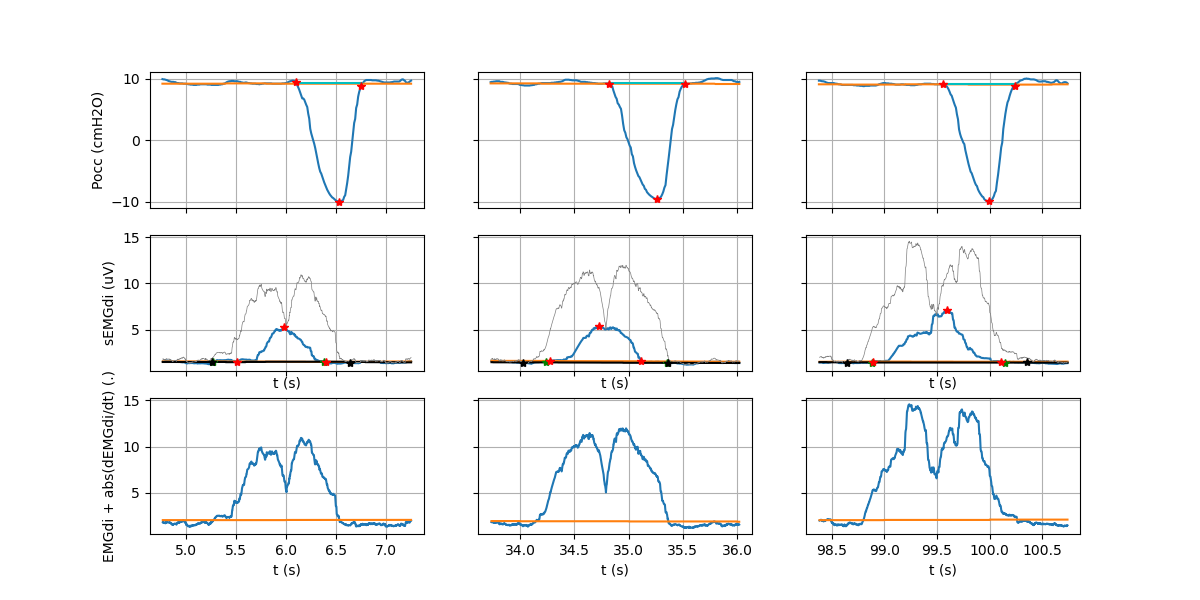

In [156]:
# TODO Delete old vs new baseline crossing illutration?
# Plot new baseline crossing detection diaphragm

#DEL fig_5, axis = plt.subplots(nrows=3, ncols=max([len(
#     P_occ_peaks),2]), figsize=(12, 6), sharex='col', sharey='row')

# # Show EMG and Paw data for entire window
# t_plot_start = np.min([[P_occ_starts / vent_sample_rate], 
#                     [EMG_di_occ_starts_new / emg_sample_rate],
#                     [EMG_di_occ_starts_old_base / emg_sample_rate], 
#                     [EMG_para_occ_starts_new / emg_sample_rate]], axis=0)[0] - 0.5
# t_plot_end = np.max([[P_occ_ends / vent_sample_rate], 
#                      [EMG_di_occ_ends_new / emg_sample_rate], 
#                      [EMG_di_occ_ends_old_base / emg_sample_rate], 
#                      [EMG_para_occ_ends_new / emg_sample_rate]], axis=0)[0] + 0.5

fig_5, axis = plt.subplots(nrows=3, ncols=max([len(
    P_occ_peaks),2]), figsize=(12, 6), sharex='col', sharey='row')

# Show EMG and Paw data for entire window
t_plot_start = np.min([[P_occ_starts / vent_sample_rate], 
                    [EMG_di_occ_starts_new / emg_sample_rate],
                    [EMG_di_occ_starts_old_base / emg_sample_rate]], axis=0)[0] - 0.5
t_plot_end = np.max([[P_occ_ends / vent_sample_rate], 
                     [EMG_di_occ_ends_new / emg_sample_rate], 
                     [EMG_di_occ_ends_old_base / emg_sample_rate]], axis=0)[0] + 0.5

PTP_occs = np.zeros((len(P_occ_peaks),))
P_aw_max = np.zeros((len(P_occ_peaks),))
PTP_occ_baseline = np.zeros((len(P_occ_peaks),))
for idx in range(len(P_occ_peaks)):
    start_i = P_occ_starts[idx]
    end_i = P_occ_ends[idx]
    start_plot_i = max([int(t_plot_start[idx] * vent_sample_rate), 0])
    end_plot_i = min(
        [int(t_plot_end[idx] * vent_sample_rate), len(x)-1])

    axis[0, idx].grid(True)
    axis[0, idx].plot(t_vent[start_plot_i:end_plot_i+1], 
                      x[start_plot_i:end_plot_i+1])
    axis[0, idx].plot(t_vent[start_plot_i:end_plot_i+1],
                      P_rolling_base_line[start_plot_i:end_plot_i+1])    

    baseline_start_i = max([0, P_occ_peaks[idx] - 5*vent_sample_rate])
    baseline_end_i = min([len(x) - 1, P_occ_peaks[idx] + 5*vent_sample_rate])
    P_aw_max[idx] = max(P_rolling_base_line[baseline_start_i:baseline_end_i])

    axis[0, idx].plot([t_vent[start_i], t_vent[end_i+1]], 
                      [P_aw_max[idx], P_aw_max[idx]], 'c')
    axis[0, idx].plot([t_vent[start_i], t_vent[start_i]], 
                      [x[start_i], P_aw_max[idx]], 'c')
    axis[0, idx].plot([t_vent[end_i], t_vent[end_i]], 
                      [x[end_i], P_aw_max[idx]], 'c')


    axis[0, idx].plot(t_vent[P_occ_peaks[idx]], x[P_occ_peaks[idx]], '*r')
    axis[0, idx].plot(t_vent[start_i], x[start_i], '*r')
    axis[0, idx].plot(t_vent[end_i], x[end_i], '*r')

axis[0, 0].set_ylabel('Pocc (cmH2O)')


y_di_min = np.zeros((len(EMG_di_occ_peaks),))
for idx in range(len(EMG_di_occ_peaks)):
    start_i = EMG_di_occ_starts_new[idx]
    end_i = EMG_di_occ_ends_new[idx]
    start_plot_i = max([int(t_plot_start[idx] * emg_sample_rate), 0])
    end_plot_i = min([int(t_plot_end[idx] * emg_sample_rate), len(y_di)-1])
    
    axis[1, idx].grid(True)
    
    axis[1, idx].plot(t_emg[start_plot_i:end_plot_i+1], 
                      y_di[start_plot_i:end_plot_i+1])
    axis[1, idx].plot(t_emg[start_plot_i:end_plot_i+1],
                      emg_di_base_factor*
                      emg_di_rolling_base_line_aug[start_plot_i:end_plot_i+1])
    axis[1, idx].plot(t_emg[start_plot_i:end_plot_i+1],
                      emg_di_rolling_base_line_old[start_plot_i:end_plot_i+1], 'k')

    baseline_start_i = max([0, EMG_di_occ_peaks[idx] - 5*emg_sample_rate])
    baseline_end_i = min(
        [len(y_di) - 1, EMG_di_occ_peaks[idx] + 5*emg_sample_rate])
    y_di_min[idx] = min(y_di[baseline_start_i:baseline_end_i])
    
    axis[1, idx].set_xlabel('t (s)')
    axis[1, idx].plot(t_emg[start_plot_i:end_plot_i], 
                      EMG_di_aug[start_plot_i:end_plot_i], 
                      'tab:gray', linewidth=0.5)
    
    axis[2, idx].grid(True)
    axis[2, idx].plot(t_emg[start_plot_i:end_plot_i], 
                      EMG_di_aug[start_plot_i:end_plot_i])
    axis[2, idx].plot(t_emg[start_plot_i:end_plot_i], 
                      emg_di_aug_rolling_base_line[start_plot_i:end_plot_i])
    axis[2, idx].set_xlabel('t (s)')
    
    axis[1, idx].plot(t_emg[EMG_di_occ_starts_old_base[idx]], 
                      y_di[EMG_di_occ_starts_old_base[idx]], '*g')
    axis[1, idx].plot(t_emg[EMG_di_occ_ends_old_base[idx]], 
                      y_di[EMG_di_occ_ends_old_base[idx]], '*g')
    axis[1, idx].plot(t_emg[EMG_di_occ_starts_new[idx]-ma_window//2], 
                        y_di[EMG_di_occ_starts_new[idx]-ma_window//2], '*k')
    axis[1, idx].plot(t_emg[EMG_di_occ_ends_new[idx]+ma_window//2], 
                        y_di[EMG_di_occ_ends_new[idx]+ma_window//2], '*k')
    axis[1, idx].plot(t_emg[EMG_di_occ_peaks[idx]],
                      y_di[EMG_di_occ_peaks[idx]], '*r')
    axis[1, idx].plot(t_emg[start_i], y_di[start_i], '*r')
    axis[1, idx].plot(t_emg[end_i], y_di[end_i], '*r')
    
                

axis[1, 0].set_ylabel('sEMGdi (uV)')
axis[2, 0].set_ylabel('EMGdi + abs(dEMGdi/dt) (.)')
print(EMG_di_occ_starts_old_base,
      EMG_di_occ_starts_new,
      EMG_di_occ_ends_old_base,
      EMG_di_occ_ends_new)

In [157]:
#DEL # Plot new baseline crossing detection parasternal
# fig_6, axis = plt.subplots(nrows=3, ncols=max([len(
#     P_occ_peaks),2]), figsize=(12, 6), sharex='col', sharey='row')

# # Show EMG and Paw data for entire window
# t_plot_start = np.min(
#     [[P_occ_starts / vent_sample_rate], 
#     [EMG_di_occ_starts_new / emg_sample_rate], 
#     [EMG_para_occ_starts_old_base / emg_sample_rate], 
#     [EMG_para_occ_starts_new / emg_sample_rate]], axis=0)[0] - 0.5
# t_plot_end = np.max(
#     [[P_occ_ends / vent_sample_rate], 
#     [EMG_di_occ_ends_new / emg_sample_rate], 
#     [EMG_para_occ_ends_old_base / emg_sample_rate], 
#     [EMG_para_occ_ends_new / emg_sample_rate]], axis=0)[0] + 0.5

# PTP_occs = np.zeros((len(P_occ_peaks),))
# P_aw_max = np.zeros((len(P_occ_peaks),))
# PTP_occ_baseline = np.zeros((len(P_occ_peaks),))
# for idx in range(len(P_occ_peaks)):
#     start_i = P_occ_starts[idx]
#     end_i = P_occ_ends[idx]
#     start_plot_i = max([int(t_plot_start[idx] * vent_sample_rate), 0])
#     end_plot_i = min(
#         [int(t_plot_end[idx] * vent_sample_rate), len(x)-1])

#     axis[0, idx].grid(True)
#     axis[0, idx].plot(t_vent[start_plot_i:end_plot_i+1], 
#                       x[start_plot_i:end_plot_i+1])
#     axis[0, idx].plot(t_vent[start_plot_i:end_plot_i+1],
#                       P_rolling_base_line[start_plot_i:end_plot_i+1])    

#     baseline_start_i = max([0, P_occ_peaks[idx] - 5*vent_sample_rate])
#     baseline_end_i = min([len(x) - 1, P_occ_peaks[idx] + 5*vent_sample_rate])
#     P_aw_max[idx] = max(P_rolling_base_line[baseline_start_i:baseline_end_i])

#     axis[0, idx].plot([t_vent[start_i], t_vent[end_i+1]], 
#                       [P_aw_max[idx], P_aw_max[idx]], 'c')
#     axis[0, idx].plot([t_vent[start_i], t_vent[start_i]], 
#                       [x[start_i], P_aw_max[idx]], 'c')
#     axis[0, idx].plot([t_vent[end_i], t_vent[end_i]], 
#                       [x[end_i], P_aw_max[idx]], 'c')


#     axis[0, idx].plot(t_vent[P_occ_peaks[idx]], x[P_occ_peaks[idx]], '*r')
#     axis[0, idx].plot(t_vent[start_i], x[start_i], '*r')
#     axis[0, idx].plot(t_vent[end_i], x[end_i], '*r')

# axis[0, 0].set_ylabel('Pocc (cmH2O)')


# y_para_min = np.zeros((len(EMG_para_occ_peaks),))
# for idx in range(len(EMG_para_occ_peaks)):
#     start_i = EMG_para_occ_starts_new[idx]
#     end_i = EMG_para_occ_ends_new[idx]
#     start_plot_i = max([int(t_plot_start[idx] * emg_sample_rate), 0])
#     end_plot_i = min([int(t_plot_end[idx] * emg_sample_rate), len(y_para)-1])
    
#     axis[1, idx].grid(True)
    
#     axis[1, idx].plot(t_emg[start_plot_i:end_plot_i+1], 
#                       y_para[start_plot_i:end_plot_i+1])
#     axis[1, idx].plot(t_emg[start_plot_i:end_plot_i+1],
#                       emg_para_base_factor *
#                       emg_para_rolling_base_line_aug[start_plot_i:end_plot_i+1])
#     axis[1, idx].plot(
#         t_emg[start_plot_i:end_plot_i+1],
#         emg_para_rolling_base_line_old[start_plot_i:end_plot_i+1], 'k')

#     baseline_start_i = max([0, EMG_para_occ_peaks[idx] - 5*emg_sample_rate])
#     baseline_end_i = min(
#         [len(y_para) - 1, EMG_para_occ_peaks[idx] + 5*emg_sample_rate])
#     y_para_min[idx] = min(y_para[baseline_start_i:baseline_end_i])

#     axis[1, idx].plot(t_emg[EMG_para_occ_peaks[idx]],
#                       y_para[EMG_para_occ_peaks[idx]], '*r')
#     axis[1, idx].plot(t_emg[start_i], y_para[start_i], '*r')
#     axis[1, idx].plot(t_emg[end_i], y_para[end_i], '*r')
    
#     axis[1, idx].set_xlabel('t (s)')
    
#     axis[2, idx].grid(True)
#     axis[2, idx].plot(t_emg[start_plot_i:end_plot_i], 
#                       EMG_para_aug[start_plot_i:end_plot_i])
#     axis[2, idx].plot(t_emg[start_plot_i:end_plot_i], 
#                       emg_para_aug_rolling_base_line[start_plot_i:end_plot_i])
#     axis[2, idx].set_xlabel('t (s)')
    
#     axis[1, idx].plot(t_emg[EMG_para_occ_starts_old_base[idx]], 
#                       y_para[EMG_para_occ_starts_old_base[idx]], '*g')
#     axis[1, idx].plot(t_emg[EMG_para_occ_ends_old_base[idx]], 
#                       y_para[EMG_para_occ_ends_old_base[idx]], '*g')
#     axis[1, idx].plot(t_emg[EMG_para_occ_starts_new[idx]-ma_window//2], 
#                         y_para[EMG_para_occ_starts_new[idx]-ma_window//2], '*k')
#     axis[1, idx].plot(t_emg[EMG_para_occ_ends_new[idx]+ma_window//2], 
#                         y_para[EMG_para_occ_ends_new[idx]+ma_window//2], '*k')
    
                
# axis[1, 0].set_ylabel('sEMGpara (uV)')
# axis[2, 0].set_ylabel('EMGpara + abs(dEMGpara/dt) (.)')

# print(
#     EMG_para_occ_starts_old_base,
#     EMG_para_occ_starts_new,
#     EMG_para_occ_ends_old_base,
#     EMG_para_occ_ends_new
# )

In [158]:
# Determine electrophysiological interpeak distance
t_delta_ecg_med = np.median(np.array(t_emg)[ECG_peaks[1:]] 
                            - np.array(t_emg)[ECG_peaks[:-1]])
t_delta_di_med = np.median(np.array(y_emg)[1, EMG_peaks_di[1:]] 
                           - np.array(y_emg)[1, EMG_peaks_di[:-1]])

In [159]:
t_delta_di_med

-2.0521240234375

(0.0, 8.5352579770645)

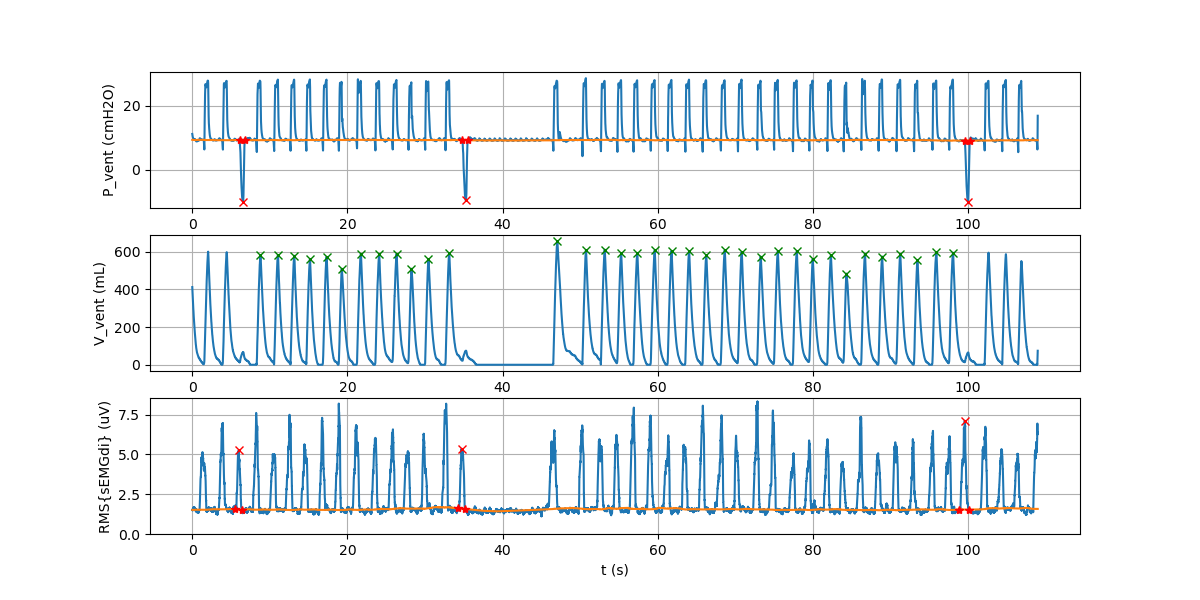

In [160]:
# Determine pneumatic interpeak distance -> Successive occluded breaths?
V_t = y_vent[2, int(start_vent_s):int(end_vent_s)]
treshold = 0.25 * np.percentile(V_t, 90)
prominence = 0.10 * np.percentile(V_t, 90)
width = 0.25 * vent_sample_rate
resp_efforts_volume_1, _ = scipy.signal.find_peaks(
    V_t, height=treshold, prominence=prominence, width=width)

treshold = 0.5 * np.percentile(V_t[resp_efforts_volume_1], 90)
prominence = 0.5 * np.percentile(V_t, 90)
width = 0.25 * vent_sample_rate
resp_efforts_volume, _ = scipy.signal.find_peaks(
    V_t, height=treshold, prominence=prominence, width=width)

# Plot entire selected time window with indicated peaks
# P_vent
#DEL fig_1, axis = plt.subplots(nrows=4, ncols=1, figsize=(12, 6))
fig_1, axis = plt.subplots(nrows=3, ncols=1, figsize=(12, 6))
axis[0].grid(True)
axis[0].plot([y / vent_sample_rate for y in range(len(x))], x)
axis[0].plot([y / vent_sample_rate for y in range(len(x))],
             P_rolling_base_line)
axis[0].plot(P_occ_peaks/vent_sample_rate, x[P_occ_peaks], "x", color="r")
axis[0].plot(P_occ_starts / vent_sample_rate,
             P_rolling_base_line[P_occ_starts], '*r')
axis[0].plot(P_occ_ends / vent_sample_rate,
             P_rolling_base_line[P_occ_ends], '*r')
axis[0].set_ylabel('P_vent (cmH2O)')

# V_vent
x_vent = y_vent[2, int(start_vent_s):int(end_vent_s)]
axis[1].grid(True)
axis[1].plot([y / vent_sample_rate for y in range(len(x))], x_vent)
axis[1].set_ylabel('V_vent (mL)')

double_dips = np.zeros((len(P_occ_peaks),))
for idx in range(len(P_occ_peaks)):
    if idx > 0 :
        intermediate_breaths = np.equal(
            (P_occ_peaks[idx-1] < resp_efforts_volume  ), 
            (resp_efforts_volume < P_occ_peaks[idx]))
        
        if len(intermediate_breaths[intermediate_breaths == True]) > 0:
            double_dips[idx] = False
        else:
            double_dips[idx] = True

        axis[1].plot(
            resp_efforts_volume[intermediate_breaths]/vent_sample_rate, 
            x_vent[resp_efforts_volume[intermediate_breaths]], "x", color="g")

    else:
        double_dips[idx] = False

# sEMGdi:
axis[2].grid(True)
N_samp = len(RMS_data_emg_di[int(start_s):int(end_s)])
axis[2].plot([y / emg_sample_rate for y in range(N_samp)],
             RMS_data_emg_di[int(start_s):int(end_s)])
axis[2].plot([y / emg_sample_rate for y in range(N_samp)],
             emg_di_base_factor*emg_di_rolling_base_line_aug[:int(end_s)-int(start_s)])
axis[2].plot(EMG_di_occ_peaks/emg_sample_rate,
             y_di[EMG_di_occ_peaks], "x", color="r")
axis[2].plot(EMG_di_occ_starts_new/ emg_sample_rate,
             y_di[EMG_di_occ_starts_new], '*r')
axis[2].plot(EMG_di_occ_ends_new / emg_sample_rate,
             y_di[EMG_di_occ_ends_new], '*r')
axis[2].set_ylabel('RMS{sEMGdi} (uV)')
axis[2].set_xlabel('t (s)')
axis[2].set_ylim([0, 1.2*max(y_di[EMG_di_occ_peaks])])

#DEL # sEMGopara
# axis[3].grid(True)
# axis[3].plot([y / emg_sample_rate for y in range(N_samp)],
#              RMS_data_emg_para[int(start_s):int(end_s)])
# axis[3].plot(EMG_para_occ_peaks/emg_sample_rate,
#              y_para[EMG_para_occ_peaks], "x", color="r")

# axis[3].plot([y / emg_sample_rate for y in range(N_samp)],
#              emg_para_base_factor*emg_para_rolling_base_line_aug[:int(end_s)-int(start_s)])
# axis[3].plot(EMG_para_occ_starts_new / emg_sample_rate,
#              y_para[EMG_para_occ_starts_new], '*r')
# axis[3].plot(EMG_para_occ_ends_new / emg_sample_rate,
#              y_para[EMG_para_occ_ends_new], '*r')
# axis[3].set_ylabel('RMS{sEMGpara} (uV)')
# axis[3].set_xlabel('t (s)')
# axis[3].set_ylim([0, 1.2*max(y_para[EMG_para_occ_peaks])])

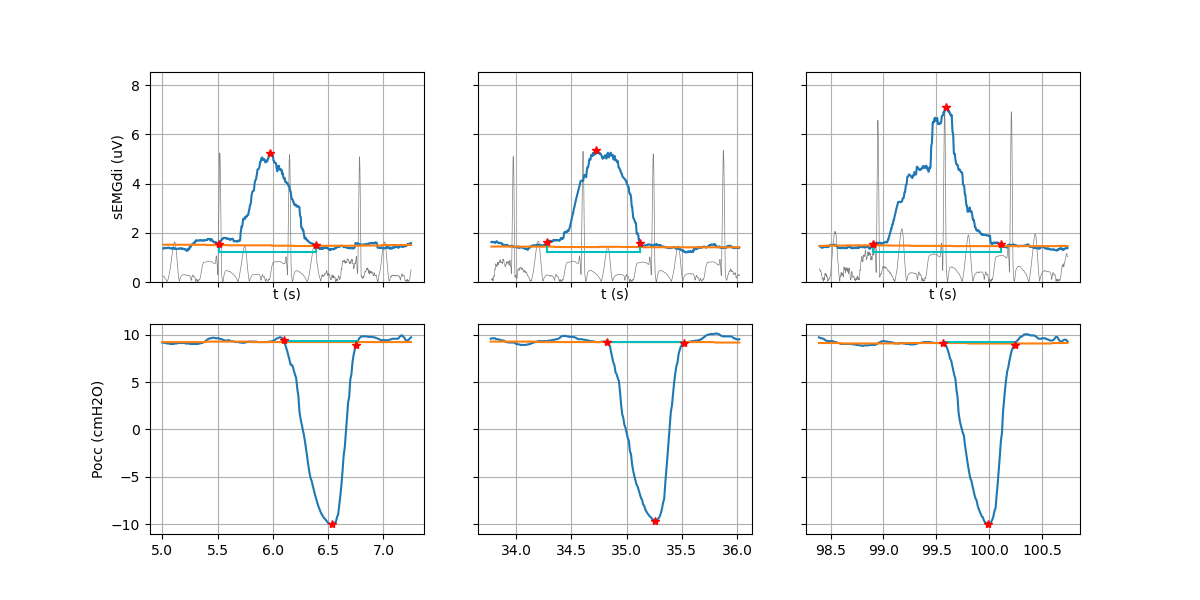

In [161]:
# Subplot per indicated peak
# TODO Shift sEMG by RMS window?

#DEL fig_2, axis = plt.subplots(nrows=3, ncols=max([len(
#     P_occ_peaks),2]), figsize=(12, 6), sharex='col', sharey='row')

# # Show EMG and Paw data for entire window
# t_plot_start = np.min([[P_occ_starts / vent_sample_rate], 
#                     [EMG_di_occ_starts_new / emg_sample_rate], 
#                     [EMG_para_occ_starts_new / emg_sample_rate]], axis=0)[0] - 0.5
# t_plot_end = np.max([[P_occ_ends / vent_sample_rate], 
#                      [EMG_di_occ_ends_new / emg_sample_rate], 
#                      [EMG_para_occ_ends_new / emg_sample_rate]], axis=0)[0] + 0.5

fig_2, axis = plt.subplots(nrows=2, ncols=max([len(
    P_occ_peaks),2]), figsize=(12, 6), sharex='col', sharey='row')

# Show EMG and Paw data for entire window
t_plot_start = np.min([[P_occ_starts / vent_sample_rate], 
                    [EMG_di_occ_starts_new / emg_sample_rate]], axis=0)[0] - 0.5
t_plot_end = np.max([[P_occ_ends / vent_sample_rate], 
                     [EMG_di_occ_ends_new / emg_sample_rate]], axis=0)[0] + 0.5

ETP_di_occs = np.zeros((len(EMG_di_occ_peaks),))
y_di_min = np.zeros((len(EMG_di_occ_peaks),))
ETP_di_baseline = np.zeros((len(EMG_di_occ_peaks),))
ETP_di_baseline_old = np.zeros((len(EMG_di_occ_peaks),))
for idx in range(len(EMG_di_occ_peaks)):
    start_i = EMG_di_occ_starts_new[idx]
    end_i = EMG_di_occ_ends_new[idx]
    start_plot_i = max([int(t_plot_start[idx] * emg_sample_rate), 0])
    end_plot_i = min([int(t_plot_end[idx] * emg_sample_rate), len(t_emg)])
    
    axis[0, idx].grid(True)
    axis[0, idx].plot(t_emg[start_plot_i:end_plot_i], 
                      ecg_rms[start_plot_i+205:end_plot_i+205]/
                      max(ecg_rms[start_plot_i+205:end_plot_i+205])*
                      max(y_di[start_plot_i:end_i]), 
                      'tab:gray', linewidth=0.5)
    
    axis[0, idx].plot(t_emg[start_plot_i:end_plot_i+1], 
                      y_di[start_plot_i:end_plot_i+1])
    axis[0, idx].plot(t_emg[start_plot_i:end_plot_i+1],
                      emg_di_rolling_base_line[start_plot_i:end_plot_i+1])

    baseline_start_i = max([0, EMG_di_occ_peaks[idx] - 5*emg_sample_rate])
    baseline_end_i = min(
        [len(y_di) - 1, EMG_di_occ_peaks[idx] + 5*emg_sample_rate])
    y_di_min[idx] = min(y_di[baseline_start_i:baseline_end_i])

    axis[0, idx].plot([t_emg[start_i], t_emg[end_i+1]], 
                      [y_di_min[idx], y_di_min[idx]], 'c')
    axis[0, idx].plot([t_emg[start_i], t_emg[start_i]], 
                      [y_di[start_i], y_di_min[idx]], 'c')
    axis[0, idx].plot([t_emg[end_i], t_emg[end_i]], 
                      [y_di[end_i], y_di_min[idx]], 'c')

    ETP_di_baseline[idx] = np.trapz(
        emg_di_base_factor*emg_di_rolling_base_line_aug[start_i:end_i+1] 
        - y_di_min[idx], dx=1/emg_sample_rate
    )

    ETP_di_baseline_old[idx] = np.trapz(
        emg_di_base_factor*emg_di_rolling_base_line[start_i:end_i+1] - y_di_min[idx],
        dx=1/emg_sample_rate
    )

    axis[0, idx].plot(t_emg[EMG_di_occ_peaks[idx]],
                      y_di[EMG_di_occ_peaks[idx]], '*r')
    axis[0, idx].plot(t_emg[start_i], y_di[start_i], '*r')
    axis[0, idx].plot(t_emg[end_i], y_di[end_i], '*r')


    
    axis[0, idx].set_ylim([0, 1.2*max(y_di[EMG_di_occ_peaks])])

    # EMG Time Product (ETP) diaphragm
    ETP_di_occs[idx] = np.trapz(
        y_di[start_i:end_i+1] - emg_di_base_factor * 
        emg_di_rolling_base_line_aug[start_i:end_i+1],
        dx=1/emg_sample_rate
    ) + ETP_di_baseline[idx]

    axis[0, idx].set_xlabel('t (s)')

axis[0, 0].set_ylabel('sEMGdi (uV)')

PTP_occs = np.zeros((len(P_occ_peaks),))
P_peak_occs = np.zeros((len(P_occ_peaks),)) # DEL 
P_aw_max = np.zeros((len(P_occ_peaks),))
PTP_occ_baseline = np.zeros((len(P_occ_peaks),))
PTP_occs_peak = np.zeros((len(P_occ_peaks),)) # DEL 
PTP_occ_peak_baseline = np.zeros((len(P_occ_peaks),)) #DEL

for idx in range(len(P_occ_peaks)):
    start_i = P_occ_starts[idx]
    end_i = P_occ_ends[idx]
    start_plot_i = max([int(t_plot_start[idx] * vent_sample_rate), 0])
    end_plot_i = min(
        [int(t_plot_end[idx] * vent_sample_rate), len(t_vent)])

    axis[1, idx].grid(True)
    axis[1, idx].plot(t_vent[start_plot_i:end_plot_i+1], 
                      x[start_plot_i:end_plot_i+1])
    axis[1, idx].plot(t_vent[start_plot_i:end_plot_i+1],
                      P_rolling_base_line[start_plot_i:end_plot_i+1])    

    baseline_start_i = max([0, P_occ_peaks[idx] - 5*vent_sample_rate])
    baseline_end_i = min([len(x) - 1, P_occ_peaks[idx] + 5*vent_sample_rate])
    P_aw_max[idx] = max(P_rolling_base_line[baseline_start_i:baseline_end_i])

    axis[1, idx].plot([t_vent[start_i], t_vent[end_i+1]], 
                      [P_aw_max[idx], P_aw_max[idx]], 'c')
    axis[1, idx].plot([t_vent[start_i], t_vent[start_i]], 
                      [x[start_i], P_aw_max[idx]], 'c')
    axis[1, idx].plot([t_vent[end_i], t_vent[end_i]], 
                      [x[end_i], P_aw_max[idx]], 'c')

    P_peak_occs[idx] = x[P_occ_peaks[idx]] #DEL
    
    PTP_occ_baseline[idx] = np.trapz(
        P_aw_max[idx] - P_rolling_base_line[start_i:end_i+1],
        dx=1/vent_sample_rate
    )

    PTP_occ_peak_baseline[idx] = np.trapz(
        P_aw_max[idx] - P_rolling_base_line[start_i:P_occ_peaks[idx]+1],
        dx=1/vent_sample_rate
    ) #DEL

    axis[1, idx].plot(t_vent[P_occ_peaks[idx]], x[P_occ_peaks[idx]], '*r')
    axis[1, idx].plot(t_vent[start_i], x[start_i], '*r')
    axis[1, idx].plot(t_vent[end_i], x[end_i], '*r')

    # Pressure Time Product (PTP) occlusion
    PTP_occs[idx] = np.abs(np.trapz(
        x[start_i:end_i+1]-P_rolling_base_line[start_i:end_i+1],
        dx=1/vent_sample_rate
    )) + PTP_occ_baseline[idx]

    PTP_occs_peak[idx] = np.abs(np.trapz(
        x[start_i:P_occ_peaks[idx]+1]
        - P_rolling_base_line[start_i:P_occ_peaks[idx]+1],
        dx=1/vent_sample_rate
    )) + PTP_occ_peak_baseline[idx] #DEL

axis[1, 0].set_ylabel('Pocc (cmH2O)')

#DEL ETP_para_occs = np.zeros((len(EMG_para_occ_peaks),))
# y_para_min = np.zeros((len(EMG_para_occ_peaks),))
# ETP_para_baseline = np.zeros((len(EMG_para_occ_peaks),))
# ETP_para_baseline_old = np.zeros((len(EMG_para_occ_peaks),))
# for idx in range(len(EMG_para_occ_peaks)):
#     start_i = EMG_para_occ_starts_new[idx]
#     end_i = EMG_para_occ_ends_new[idx]
#     start_plot_i = max([int(t_plot_start[idx] * emg_sample_rate), 0])
#     end_plot_i = min([int(t_plot_end[idx] * emg_sample_rate), len(t_emg)])

#     axis[2, idx].grid(True)
#     axis[2, idx].plot(t_emg[start_plot_i:end_plot_i], 
#                     ecg_rms[start_plot_i+205:end_plot_i+205]/
#                     max(ecg_rms[start_plot_i+205:end_plot_i+205])*
#                     max(y_para[start_plot_i:end_plot_i]), 
#                     'tab:gray', linewidth=0.5)
#     axis[2, idx].plot(t_emg[start_plot_i:end_plot_i+1], 
#                       y_para[start_plot_i:end_plot_i+1])
#     axis[2, idx].plot(t_emg[start_plot_i:end_plot_i+1],
#                       emg_para_rolling_base_line[start_plot_i:end_plot_i+1])
    
#     baseline_start_i = max([0, EMG_para_occ_peaks[idx] - 5*emg_sample_rate])
#     baseline_end_i = min(
#         [len(y_para) - 1, EMG_para_occ_peaks[idx] + 5*emg_sample_rate])
#     y_para_min[idx] = min(y_para[baseline_start_i:baseline_end_i])

#     axis[2, idx].plot([t_emg[start_i], t_emg[end_i+1]], 
#                       [y_para_min[idx], y_para_min[idx]], 'c')
#     axis[2, idx].plot([t_emg[start_i], t_emg[start_i]], 
#                       [y_para[start_i], y_para_min[idx]], 'c')
#     axis[2, idx].plot([t_emg[end_i], t_emg[end_i]], 
#                       [y_para[end_i], y_para_min[idx]], 'c')

#     ETP_para_baseline[idx] = np.trapz(emg_para_base_factor*
#         emg_para_rolling_base_line_aug[start_i:end_i+1] - y_para_min[idx],
#         dx=1/emg_sample_rate
#     )

#     ETP_para_baseline_old[idx] = np.trapz(
#         emg_para_rolling_base_line[start_i:end_i+1] - y_para_min[idx],
#         dx=1/emg_sample_rate
#     )

#     axis[2, idx].plot(t_emg[EMG_para_occ_peaks[idx]],
#                       y_para[EMG_para_occ_peaks[idx]], '*r')
#     axis[2, idx].plot(t_emg[start_i], y_para[start_i], '*r')
#     axis[2, idx].plot(t_emg[end_i], y_para[end_i], '*r')

#     # EMG Time Product (ETP) parasternal
#     ETP_para_occs[idx] = np.trapz(y_para[start_i:end_i+1] 
#         - emg_para_base_factor *emg_para_rolling_base_line_aug[start_i:end_i+1],
#         dx=1/emg_sample_rate
#     ) + ETP_para_baseline[idx]

#     axis[2, idx].set_xlabel('t (s)')

# axis[2, 0].set_ylabel('sEMGpara (uV)')


# Calculated neuromuscular efficiency: NMC = PTP / ETP_di
NMC_di = np.abs(PTP_occs)/ETP_di_occs

SNR_di = feat.snr_pseudo(
    src_signal=RMS_data_emg_di[int(start_s):int(end_s)], 
    peaks=EMG_di_occ_peaks, 
    baseline=emg_di_base_factor*
        emg_di_rolling_base_line_aug[:int(end_s)-int(start_s)]\
)
#DEL SNR_para = feat.snr_pseudo(
#     src_signal=RMS_data_emg_para[int(start_s):int(end_s)], 
#     peaks=EMG_para_occ_peaks, 
#     baseline= emg_para_base_factor*
#         emg_para_rolling_base_line_aug[:int(end_s)-int(start_s)]    
# )

Text(0, 0.5, 'Sample count (.)')

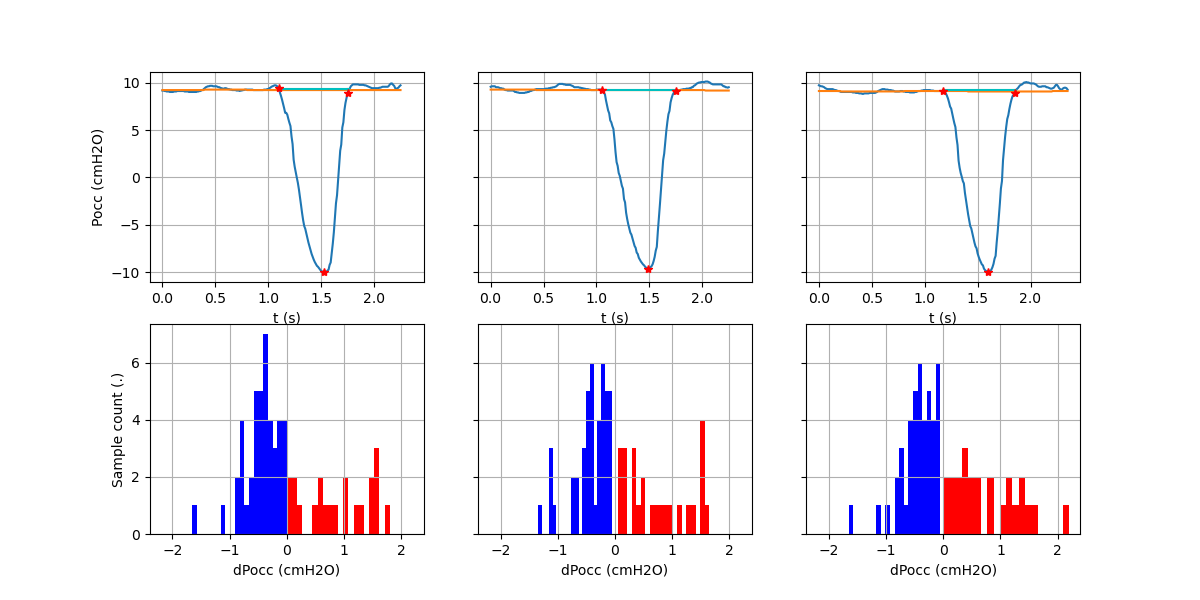

In [162]:
# dPocc in up and downslope comparison for early release detection

fig_4, axis_tmp = plt.subplots(nrows=2, ncols=max([len(
    P_occ_peaks),2]), figsize=(12, 6), sharex='row', sharey='row')

t_vent = np.array(t_vent)

n_bins = 20
# PTP_occs
dP_up_10 = np.zeros((len(P_occ_peaks),))
dP_up_90 = np.zeros((len(P_occ_peaks),))
for idx in range(len(P_occ_peaks)):

    start_i = P_occ_starts[idx]
    end_i = P_occ_ends[idx]
    start_plot_i = max([int(t_plot_start[idx] * vent_sample_rate), 0])
    end_plot_i = min(
        [int(t_plot_end[idx] * vent_sample_rate), len(x)-1])
    
    # P_vent-time plots
    axis_tmp[0, idx].grid(True)
    axis_tmp[0, idx].plot(
        t_vent[start_plot_i:end_plot_i+1] - t_vent[start_plot_i], 
        x[start_plot_i:end_plot_i+1])
    axis_tmp[0, idx].plot(
        t_vent[start_plot_i:end_plot_i+1]- t_vent[start_plot_i],
        P_rolling_base_line[start_plot_i:end_plot_i+1])    

    baseline_start_i = max([0, P_occ_peaks[idx] - 5*vent_sample_rate])
    baseline_end_i = min([len(x) - 1, P_occ_peaks[idx] + 5*vent_sample_rate])
    P_aw_max[idx] = max(P_rolling_base_line[baseline_start_i:baseline_end_i])

    axis_tmp[0, idx].plot(
        [t_vent[start_i], t_vent[end_i+1]] - t_vent[start_plot_i], 
        [P_aw_max[idx], P_aw_max[idx]], 'c')
    axis_tmp[0, idx].plot(
        [t_vent[start_i], t_vent[start_i]] - t_vent[start_plot_i], 
        [x[start_i], P_aw_max[idx]], 'c')
    axis_tmp[0, idx].plot(
        [t_vent[end_i], t_vent[end_i]] - t_vent[start_plot_i], 
        [x[end_i], P_aw_max[idx]], 'c')

    axis_tmp[0, idx].plot(t_vent[P_occ_peaks[idx]] - t_vent[start_plot_i],
                    x[P_occ_peaks[idx]], '*r')
    axis_tmp[0, idx].plot(t_vent[start_i] - t_vent[start_plot_i],
                      x[start_i], '*r')
    axis_tmp[0, idx].plot(t_vent[end_i] - t_vent[start_plot_i], 
                      x[end_i], '*r')
    axis_tmp[0, idx].set_xlabel('t (s)')

    dP_up_10[idx] = np.percentile(
        x[P_occ_peaks[idx]+1:end_i]-x[P_occ_peaks[idx]:end_i-1], 10)
    dP_up_90[idx] = np.percentile(
        x[P_occ_peaks[idx]+1:end_i]-x[P_occ_peaks[idx]:end_i-1], 90)
    
    # Histogram of dPocc/dx in down- (blue) and upslope (red)
    axis_tmp[1, idx].grid(True)
    axis_tmp[1, idx].hist(
        x[start_i+1:P_occ_peaks[idx]+1]-x[start_i:P_occ_peaks[idx]], 
        bins=n_bins, color='b')

    axis_tmp[1, idx].grid(True)
    axis_tmp[1, idx].hist(
        x[P_occ_peaks[idx]+1:end_i]-x[P_occ_peaks[idx]:end_i-1], 
        bins=n_bins, color='r')

    axis_tmp[1, idx].set_xlabel('dPocc (cmH2O)')

# Make x-axes symmetric in y-axis
low, high = axis_tmp[1, 0].get_xlim()
bound = max(abs(low), abs(high))
axis_tmp[1, 0].set_xlim(-bound, bound)
axis_tmp[0, 0].set_ylabel('Pocc (cmH2O)')
axis_tmp[1, 0].set_ylabel('Sample count (.)')


Text(0, 0.5, 'Pocc (cmH2O)')

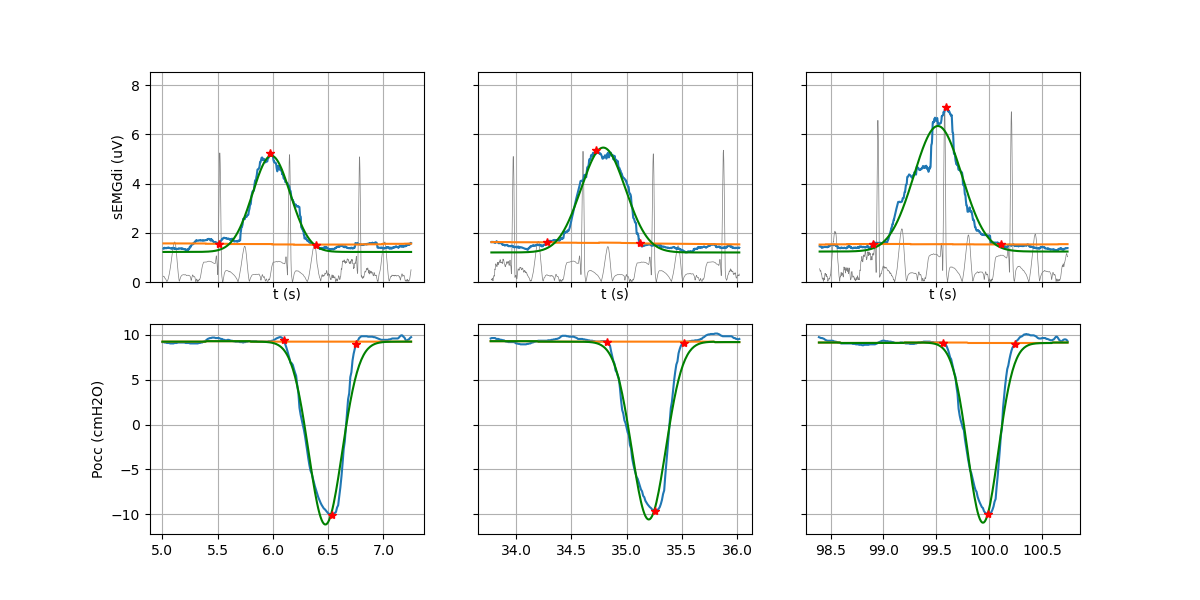

In [163]:
# Fit to bell plots
#DEL fig_3, axis = plt.subplots(nrows=3, ncols=max([len(
#     P_occ_peaks), 2]), figsize=(12, 6), sharex='col', sharey='row')

# # Show EMG and Paw data for entire window
# t_plot_start = np.min([[P_occ_starts / vent_sample_rate], 
#                     [EMG_di_occ_starts_new/ emg_sample_rate], 
#                     [EMG_para_occ_starts_new / emg_sample_rate]], axis=0)[0] - 0.5
# t_plot_end = np.max([[P_occ_ends / vent_sample_rate], 
#                      [EMG_di_occ_ends_new / emg_sample_rate], 
#                      [EMG_para_occ_ends_new / emg_sample_rate]], axis=0)[0] + 0.5

fig_3, axis = plt.subplots(nrows=2, ncols=max([len(
    P_occ_peaks), 2]), figsize=(12, 6), sharex='col', sharey='row')

# Show EMG and Paw data for entire window
t_plot_start = np.min([[P_occ_starts / vent_sample_rate], 
                    [EMG_di_occ_starts_new/ emg_sample_rate]], axis=0)[0] - 0.5
t_plot_end = np.max([[P_occ_ends / vent_sample_rate], 
                     [EMG_di_occ_ends_new / emg_sample_rate]], axis=0)[0] + 0.5

from scipy.optimize import curve_fit

def func(x, a, b, c):
    return a * np.exp(-(x-b)**2 / c**2)

ETP_di_bell_error = np.zeros((len(EMG_di_occ_peaks),))
for idx in range(len(EMG_di_occ_peaks)):
    start_i = EMG_di_occ_starts_new[idx]
    end_i = EMG_di_occ_ends_new[idx]
    start_plot_i = max([int(t_plot_start[idx] * emg_sample_rate), 0])
    end_plot_i = min([int(t_plot_end[idx] * emg_sample_rate), len(y_di)-1])
    
    axis[0, idx].grid(True)
    axis[0, idx].plot(t_emg[start_plot_i:end_plot_i], 
                      ecg_rms[start_plot_i+205:end_plot_i+205]/
                      max(ecg_rms[start_plot_i+205:end_plot_i+205])*
                      max(y_di[start_plot_i:end_i]), 
                      'tab:gray', linewidth=0.5)
    
    axis[0, idx].plot(t_emg[start_plot_i:end_plot_i+1], 
                      y_di[start_plot_i:end_plot_i+1])
    axis[0, idx].plot(t_emg[start_plot_i:end_plot_i+1],
                      emg_di_base_factor*
                      emg_di_rolling_base_line_aug[start_plot_i:end_plot_i+1])
    
    baseline_start_i = max([0, EMG_di_occ_peaks[idx] - 5*emg_sample_rate])
    baseline_end_i = min(
        [len(y_di) - 1, EMG_di_occ_peaks[idx] + 5*emg_sample_rate])
    y_di_min[idx] = min(y_di[baseline_start_i:baseline_end_i])

    # Too little samples to fit parameters to --> Add additional datapoints
    if end_i - start_i < 3:
        plus_idx = 3 - (end_i - start_i)
    else:
        plus_idx = 0
    popt, pcov = curve_fit(func, 
                    t_emg[start_i:end_i+1], 
                    y_di[start_i:end_i+1]-y_di_min[idx],
                    bounds=([0., t_emg[EMG_di_occ_peaks[idx]]-0.5, 0.], 
                            [60., t_emg[EMG_di_occ_peaks[idx]]+0.5, 0.5])
                    )

    ETP_di_bell_error[idx] = np.trapz(
        np.sqrt((y_di[start_i:end_i+1] - 
        (func(t_emg[start_i:end_i+1], *popt)+y_di_min[idx])) **2),
        dx=1/emg_sample_rate
    )

    axis[0, idx].plot(t_emg[start_plot_i:end_plot_i+1], 
                      func(t_emg[start_plot_i:end_plot_i+1], *popt)
                      + y_di_min[idx], 'g')
    


    axis[0, idx].plot(t_emg[EMG_di_occ_peaks[idx]],
                      y_di[EMG_di_occ_peaks[idx]], '*r')
    axis[0, idx].plot(t_emg[start_i], y_di[start_i], '*r')
    axis[0, idx].plot(t_emg[end_i], y_di[end_i], '*r')

    axis[0, idx].set_ylim([0, 1.2*max(y_di[EMG_di_occ_peaks])])

    axis[0, idx].set_xlabel('t (s)')

axis[0, 0].set_ylabel('sEMGdi (uV)')

PTP_occ_bell_error = np.zeros((len(EMG_di_occ_peaks),))
for idx in range(len(P_occ_peaks)):
    start_i = P_occ_starts[idx]
    end_i = P_occ_ends[idx]
    start_plot_i = max([int(t_plot_start[idx] * vent_sample_rate), 0])
    end_plot_i = min(
        [int(t_plot_end[idx] * vent_sample_rate), len(x)-1])

    axis[1, idx].grid(True)
    axis[1, idx].plot(t_vent[start_plot_i:end_plot_i+1], 
                      x[start_plot_i:end_plot_i+1])
    axis[1, idx].plot(t_vent[start_plot_i:end_plot_i+1],
                      P_rolling_base_line[start_plot_i:end_plot_i+1])
    

    baseline_start_i = max([0, P_occ_peaks[idx] - 5*vent_sample_rate])
    baseline_end_i = min([len(x) - 1, P_occ_peaks[idx] + 5*vent_sample_rate])
    P_aw_max[idx] = max(P_rolling_base_line[baseline_start_i:baseline_end_i])

    popt, pcov = curve_fit(func, 
                        t_vent[start_i:end_i+1], 
                        -(x[start_i:end_i+1]-P_aw_max[idx]),
                        bounds=([0., t_vent[P_occ_peaks[idx]]-0.5, 0.], 
                                [100., t_vent[P_occ_peaks[idx]]+0.5, 0.5])
                        )
    
    PTP_occ_bell_error[idx] = np.trapz(
        np.sqrt((x[start_i:end_i+1] - 
        (-func(t_vent[start_i:end_i+1], *popt)+P_aw_max[idx])) **2),
        dx=1/vent_sample_rate
    )
    axis[1, idx].plot(t_vent[start_plot_i:end_plot_i+1], 
                    -func(t_vent[start_plot_i:end_plot_i+1], *popt)
                    + P_rolling_base_line[start_plot_i:end_plot_i+1], 'g')

    axis[1, idx].plot(t_vent[P_occ_peaks[idx]], x[P_occ_peaks[idx]], '*r')
    axis[1, idx].plot(t_vent[start_i], x[start_i], '*r')
    axis[1, idx].plot(t_vent[end_i], x[end_i], '*r')


axis[1, 0].set_ylabel('Pocc (cmH2O)')
#DEL ETP_para_bell_error = np.zeros((len(EMG_para_occ_peaks),))
# for idx in range(len(EMG_para_occ_peaks)):
#     start_i = EMG_para_occ_starts_new[idx]
#     end_i = EMG_para_occ_ends_new[idx]
#     start_plot_i = max([int(t_plot_start[idx] * emg_sample_rate), 0])
#     end_plot_i = min([int(t_plot_end[idx] * emg_sample_rate), len(y_para)-1])

#     axis[2, idx].grid(True)
#     axis[2, idx].plot(t_emg[start_plot_i:end_plot_i], 
#                     ecg_rms[start_plot_i+205:end_plot_i+205]/
#                     max(ecg_rms[start_plot_i+205:end_plot_i+205])*
#                     max(y_para[start_plot_i:end_plot_i]), 
#                     'tab:gray', linewidth=0.5)
#     axis[2, idx].plot(t_emg[start_plot_i:end_plot_i+1], 
#                       y_para[start_plot_i:end_plot_i+1])
#     axis[2, idx].plot(t_emg[start_plot_i:end_plot_i+1],
#                       emg_para_base_factor*
#                       emg_para_rolling_base_line_aug[start_plot_i:end_plot_i+1])
#     baseline_start_i = max([0, EMG_para_occ_peaks[idx] - 5*emg_sample_rate])
#     baseline_end_i = min(
#         [len(y_para) - 1, EMG_para_occ_peaks[idx] + 5*emg_sample_rate])
#     y_para_min[idx] = min(y_para[baseline_start_i:baseline_end_i])

#     # Too little samples to fit parameters to --> Add additional datapoints 
#     if end_i - start_i < 3:
#         plus_idx = 3 - (end_i - start_i)
#     else:
#         plus_idx = 0

#     popt, pcov = curve_fit(func, 
#                         t_emg[start_i:end_i+1+plus_idx], 
#                         y_para[start_i:end_i+1+plus_idx]-y_para_min[idx],
#                         bounds=([0., t_emg[EMG_para_occ_peaks[idx]]-0.5, 0.], 
#                                 [60., t_emg[EMG_para_occ_peaks[idx]]+0.5, 0.5])
#                         )
    
#     ETP_para_bell_error[idx] = np.trapz(
#         np.sqrt((y_para[start_i:end_i+1] - 
#         (func(t_emg[start_i:end_i+1], *popt)+y_para_min[idx])) **2),
#         dx=1/emg_sample_rate
#     )

#     axis[2, idx].plot(t_emg[start_plot_i:end_plot_i+1], 
#                       func(t_emg[start_plot_i:end_plot_i+1], *popt)
#                       +y_para_min[idx], 'g')

#     axis[2, idx].plot(t_emg[EMG_para_occ_peaks[idx]],
#                       y_para[EMG_para_occ_peaks[idx]], '*r')
#     axis[2, idx].plot(t_emg[start_i], y_para[start_i], '*r')
#     axis[2, idx].plot(t_emg[end_i], y_para[end_i], '*r')

    

#     axis[2, idx].set_xlabel('t (s)')

# axis[2, 0].set_ylabel('sEMGpara (uV)')


In [164]:
# TODO Criteria met: Y/N table-like?

# Store values for later analysis

In [165]:
fig_1.savefig(main_output_dir + '/' + patient + '/' + measurement_date
              + '/' + measurement_date + '_' + patient + '_' + PEEP_step_chosen 
              + '_timeplots_'+str(int(gate_width*1000))+'.png', 
              dpi=300)
fig_2.savefig(main_output_dir + '/' + patient + '/' + measurement_date  
              + '/' + measurement_date + '_' + patient + '_' + PEEP_step_chosen 
              + '_snapshots_'+str(int(gate_width*1000))+'.png', 
              dpi=300)
fig_3.savefig(main_output_dir + '/' + patient + '/' + measurement_date  
              + '/' + measurement_date + '_' + patient + '_' + PEEP_step_chosen 
              + '_bell_errors_'+str(int(gate_width*1000))+'.png', 
              dpi=300)

fig_4.savefig(main_output_dir + '/' + patient + '/' + measurement_date  
              + '/' + measurement_date + '_' + patient + '_' + PEEP_step_chosen 
              + '_Pocc_slopes_'+str(int(gate_width*1000))+'.png', 
              dpi=300)

In [166]:
# Store the output parameters in a dataframe
for idx in range(len(PTP_occs)):
    data_now = [patient, PEEP_step_chosen, PEEP_set, PTP_occs[idx],
                ETP_di_occs[idx], NMC_di[idx],
                SNR_di[idx],
                PTP_occ_baseline[idx], ETP_di_baseline[idx], 
                ETP_di_baseline_old[idx],
                PTP_occ_bell_error[idx], ETP_di_bell_error[idx], 
                PTP_occs_peak[idx], PTP_occ_peak_baseline[idx],
                t_delta_di_med, t_delta_ecg_med,
                P_occ_peaks[idx]/vent_sample_rate, 
                P_occ_starts[idx]/vent_sample_rate, 
                P_occ_ends[idx]/vent_sample_rate,
                EMG_di_occ_peaks[idx]/emg_sample_rate, 
                EMG_di_occ_starts_new[idx]/emg_sample_rate, 
                EMG_di_occ_ends_new[idx]/emg_sample_rate,
                dP_up_10[idx], dP_up_90[idx], double_dips[idx],
                ]
    
    big_data_list.append(data_now)

    columns_now = ['patient', 'measurement', 'PEEP_set', 'PTP_occs', 'ETP_di_occs', 
               'NMC_di', 'SNR_di',
               'PTP_occ_baseline', 'ETP_di_baseline', 'ETP_di_baseline_old', 
               'PTP_occ_bell_SE', 'ETP_di_bell_SE',
               'PTP_occs_peak', 'PTP_occ_peak_baseline', 
               't_delta_di_med', 't_delta_ecg_med', 
               't_Pocc_peak', 't_Pocc_start', 't_Pocc_end',
               't_di_peak', 't_di_start', 't_di_end',
               'dP_up_10', 'dP_up_90', 'double_dip'
               ]

df = pd.DataFrame(big_data_list, columns=columns_now)
df


,patient,measurement,PEEP_set,PTP_occs,ETP_di_occs,NMC_di,SNR_di,PTP_occ_baseline,ETP_di_baseline,ETP_di_baseline_old,...,t_delta_ecg_med,t_Pocc_peak,t_Pocc_start,t_Pocc_end,t_di_peak,t_di_start,t_di_end,dP_up_10,dP_up_90,double_dip
0,MST001,006,3.0,6.151575,1.213061,5.071117,2.335186,0.130836,0.286303,0.239228,...,0.616943,5.22,4.57,5.43,4.712891,4.269531,5.232422,0.235090,1.47032,0.0
1,MST001,006,3.0,6.288096,1.836622,3.423728,3.416553,0.092564,0.269034,0.222802,...,0.616943,7.37,6.94,7.58,6.955078,6.492676,7.400879,0.135090,1.40030,1.0
2,MST001,006,3.0,7.216023,1.629842,4.427437,3.051880,0.088250,0.349932,0.294290,...,0.616943,29.70,29.23,29.94,29.145020,28.850586,29.909180,0.110000,1.43040,0.0
3,MST001,006,3.0,6.714154,1.320103,5.086084,2.830859,0.057750,0.277705,0.249649,...,0.616943,41.02,40.57,41.26,40.519043,40.124023,41.102539,0.140000,1.38038,0.0
4,MST001,007,5.0,7.810247,1.832666,4.261687,3.128684,0.157914,0.310873,0.264066,...,0.624023,3.86,2.99,4.13,3.384766,2.848145,3.739746,0.075000,1.50035,0.0
5,MST001,007,5.0,6.951271,1.758169,3.953698,3.043975,0.076318,0.375247,0.287468,...,0.624023,19.72,19.28,19.96,19.123535,18.885742,19.859375,0.070020,1.50038,0.0
6,MST001,007,5.0,6.578860,1.419585,4.634354,3.006193,0.034000,0.319505,0.282880,...,0.624023,39.69,39.24,39.92,39.125488,38.927246,39.880859,0.255100,1.39539,0.0
7,MST001,008,7.0,7.765417,2.057289,3.774588,3.813563,0.056050,0.402632,0.335305,...,0.627441,2.25,1.78,2.49,1.612793,1.204590,2.215820,0.110080,1.45038,0.0
8,MST001,008,7.0,7.123509,1.976091,3.604849,3.119741,0.142250,0.372030,0.289881,...,0.627441,32.80,32.32,33.05,32.311523,31.810059,32.671875,0.200100,1.33533,0.0
9,MST001,008,7.0,6.988486,1.691393,4.131794,3.556006,0.032500,0.322547,0.268018,...,0.627441,64.72,64.30,64.95,64.215820,63.624512,64.512695,0.055000,1.55040,0.0


Text(0.5, 1.0, '')

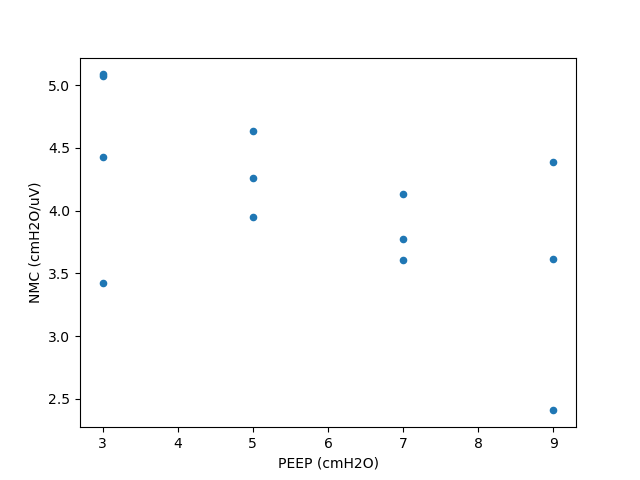

In [167]:
bp = df.plot.scatter('PEEP_set', 'NMC_di')
bp.set_ylabel('NMC (cmH2O/uV)')
bp.set_xlabel('PEEP (cmH2O)')
bp.set_title('')

In [168]:
# Generate read-me file and save it
if gate_twice == True:
    N_gated = 2
else:
    N_gated = 1

context = (patient + ' / ' + measurement_date + ' / ' + PEEP_step_chosen + '\n'
        +'t_start: ' + str(start) + ' s' + '\n'
        +'t_end: ' + str(end) + ' s' + '\n'
        +'gate_width: ' + str(int(gate_width*1000)) + ' ms' + '\n'
        +'gate_threshold: ' + str(peak_fraction) + '' + '\n'
        +'gate_ECG_shift: ' + str(ECG_shift) + ' samples' + '\n'
        +'time_shift: ' + str(vent_delay) + ' s' + '\n'
        +'Pocc_prominence_factor: ' + str(Pocc_prominence_factor) 
        + '' + '\n'
        +'EMG_di_prominence_factor: ' + str(EMG_di_prominence_factor) 
        + '' + '\n'
        +'PEEP_set: ' + str(PEEP_set) + '' + '\n' \
        +'N_gated: ' + str(N_gated) + '' + '\n' \
        +'augmented_percentile: ' + str(augmented_perc) + ' %' + '\n'
        +'emg_baseline_factor: ' + str(emg_baseline_factor) + '\n'
        +'emg_di_baseline_factor: ' + str(emg_di_base_factor) + '\n'
        +'analysis_date: ' + str(datetime.now()) + ''
        )

with open(main_output_dir + '/' + patient + '/' + measurement_date + '/' 
          + measurement_date + '_' + patient + '_' + PEEP_step_chosen 
          + '_readme.txt', 'w') as f:
    f.write(context)

print(context)

MST001 / 2021-12-24_09-29-46 / 009
t_start: 210.0 s
t_end: 319.0 s
gate_width: 100 ms
gate_threshold: 0.3
gate_ECG_shift: -10 samples
time_shift: 0.5 s
Pocc_prominence_factor: 0.8
EMG_di_prominence_factor: 1.0
PEEP_set: 9.0
N_gated: 1
augmented_percentile: 25 %
emg_baseline_factor: 1.0
emg_di_baseline_factor: 1
analysis_date: 2023-12-21 15:27:31.789942


In [169]:
# Store PEEP-trial data if all PEEP-levels have been analysed
if len(set(df['PEEP_set'].values)) < 4:
    print('Warning: Not 4 PEEP settings evaluated yet!')
else:
    df.to_csv(main_output_dir + '/' + patient + '/' + measurement_date  
              + '/' + measurement_date + '_' + patient
              +'_NMC_output_gate_'+str(int(gate_width*1000)) + '.csv')

    bp.figure.savefig(main_output_dir + '/' + patient + '/' 
                      + measurement_date  + '/' + measurement_date 
                      + '_' + patient + '_gate_'+str(int(gate_width*1000)) 
                      + '_scatter.png', dpi=300)
    
    print('Notification: Data of 4 PEEP settings stored!')
    print(measurement_date)

Notification: Data of 4 PEEP settings stored!
2021-12-24_09-29-46


In [170]:
# Move on to the next measurement date if data saved

if not os.path.exists(main_output_dir + '/' + patient + '/' 
                      + measurement_date  + '/' + measurement_date 
                      + '_' + patient + '_NMC_output_gate_'
                      + str(int(gate_width*1000))+'.csv'):
    print('Warning: Data not stored! Do not progress to next date!')
elif len(set(df['PEEP_set'].values)) < 4:
    print('Warning: Data not stored! Do not progress to next date!')
else:
    if date_idx < len(measurement_dates):
        print('Notification: Data appropriately stored. '
              +'You may progress to next date!')
    else:
        print('Notification: Data appropriately stored. \n'+
              'This was the last measurement of this patient. '
              +'You may progress to next patient!')

Notification: Data appropriately stored. You may progress to next date!
